In [1]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math

from sklearn import metrics
from random import randint
from matplotlib import style

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('curriculum_logs.csv')

# concatenate and change date type columns to the respective type 
df['date_time'] = df.date + ' ' + df.time
df.date_time = pd.to_datetime(df.date_time, format = '%Y-%m-%d %H:%M:%S')
df.date = pd.to_datetime(df.date)
df.time = pd.to_datetime(df.time).dt.time
df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)
df.created_at = pd.to_datetime(df.created_at)
df.deleted_at = pd.to_datetime(df.deleted_at)

# missing entirety of columns
df.drop(['Unnamed: 0', 'id', 'slack','deleted_at'], inplace = True, axis = 1)

# let's clean up the dataset
df.dropna(inplace = True)

# set the index
df = df.set_index(df.date)

# let's rename some columns
df.rename(columns = {'path':'endpoint', 'ip':'source_ip', 'name':'cohort_name'}, inplace = True)

# let's remove the staff members since this exercise pertains to students
df = df[df['cohort_name'] != 'Staff']

# add program name and course to dataframe
df['program_name'] = df.program_id.map({1.0: 'PHP Full Stack Web Development',
                                        2.0: 'Java Full Stack Web Development',
                                        3.0: 'Data Science',
                                        4.0: 'Front End Web Development'})

df['course'] = df.program_id.map({1.0: 'Web Development',
                                   2.0: 'Web Development',
                                   3.0: 'Data Science',
                                   4.0: 'Web Development'})

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 763298 entries, 2018-01-26 to 2021-04-21
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          763298 non-null  datetime64[ns]
 1   time          763298 non-null  object        
 2   endpoint      763298 non-null  object        
 3   user_id       763298 non-null  int64         
 4   cohort_id     763298 non-null  float64       
 5   source_ip     763298 non-null  object        
 6   cohort_name   763298 non-null  object        
 7   start_date    763298 non-null  datetime64[ns]
 8   end_date      763298 non-null  datetime64[ns]
 9   created_at    763298 non-null  datetime64[ns]
 10  updated_at    763298 non-null  object        
 11  program_id    763298 non-null  float64       
 12  date_time     763298 non-null  datetime64[ns]
 13  program_name  763298 non-null  object        
 14  course        763298 non-null  object        
dtypes

In [3]:
df.head()

date      time                             endpoint  user_id  \
date                                                                            
2018-01-26 2018-01-26  09:55:03                                    /        1   
2018-01-26 2018-01-26  09:56:02                              java-ii        1   
2018-01-26 2018-01-26  09:56:05  java-ii/object-oriented-programming        1   
2018-01-26 2018-01-26  09:56:06   slides/object_oriented_programming        1   
2018-01-26 2018-01-26  09:56:24            javascript-i/conditionals        2   

            cohort_id     source_ip cohort_name start_date   end_date  \
date                                                                    
2018-01-26        8.0  97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26        8.0  97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26        8.0  97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26        8.0  97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26       22.0  97.105.19.61       Teddy 2018-01-08 2018-05-17   

                    created_at           updated_at  program_id  \
date                                                              
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2018-01-08 13:59:10  2018-01-08 13:59:10         2.0   

                     date_time                     program_name  \
date                                                              
2018-01-26 2018-01-26 09:55:03   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:02   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:05   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:06   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:24  Java Full Stack Web Development   

                     course  
date                         
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development

1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [4]:
cohort_program = pd.DataFrame(columns = ['cohort','program_name'])
for cohort in df.cohort_name.unique():
    for program in df[df['cohort_name'] == cohort].program_name.unique():
        cohort_program = cohort_program.append({'cohort':cohort, 'program_name':program}, ignore_index = True)
cohort_program.T

0                                1   \
cohort                               Hampton                            Teddy   
program_name  PHP Full Stack Web Development  Java Full Stack Web Development   

                                           2                               3   \
cohort                                Sequoia                          Arches   
program_name  Java Full Stack Web Development  PHP Full Stack Web Development   

                                           4   \
cohort                                Niagara   
program_name  Java Full Stack Web Development   

                                           5                               6   \
cohort                              Pinnacles                          Quincy   
program_name  Java Full Stack Web Development  PHP Full Stack Web Development   

                                          7                               8   \
cohort                                 Kings                          Lassen   
program_name  PHP Full Stack Web Development  PHP Full Stack Web Development   

                                           9   ...            36  \
cohort                                Mammoth  ...        Darden   
program_name  Java Full Stack Web Development  ...  Data Science   

                                           37  \
cohort                                   Bash   
program_name  Java Full Stack Web Development   

                                           38  \
cohort                                Jupiter   
program_name  Java Full Stack Web Development   

                                           39  \
cohort                                Kalypso   
program_name  Java Full Stack Web Development   

                                           40            41  \
cohort                                   Luna        Easley   
program_name  Java Full Stack Web Development  Data Science   

                                           42  \
cohort                                  Marco   
program_name  Java Full Stack Web Development   

                                           43            44  \
cohort                                Neptune      Florence   
program_name  Java Full Stack Web Development  Data Science   

                                           45  
cohort                                 Oberon  
program_name  Java Full Stack Web Development  

[2 rows x 46 columns]

In [5]:
df_dw = df.copy()

In [6]:
# after going through the contents of the endpoint feature, the following words were 
# identified and need to be removed as these are only elements of the web page or the 
# introductory page
dropped_words = ['/', '.jpg', '.json', '.gif', '.png', '.jpeg', '.svg']

In [7]:
# let's remove the words in the dropped_words list
for word in dropped_words:
    df_dw = df_dw[~df_dw['endpoint'].str.endswith(word)]

In [8]:
df_dw[df_dw['program_name'] == 'Data Science'].endpoint.nunique()

631

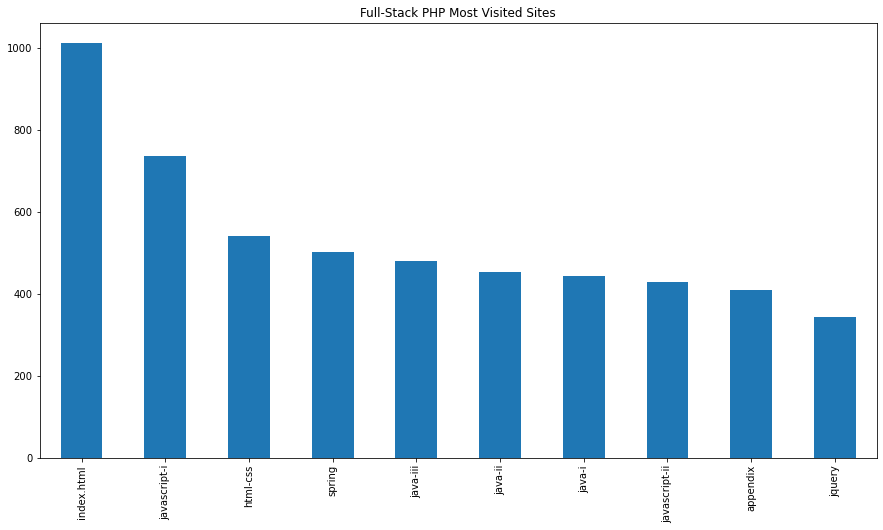

In [9]:
df_dw[df_dw['program_name'] == 'PHP Full Stack Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Full-Stack PHP Most Visited Sites', figsize = (15,8));

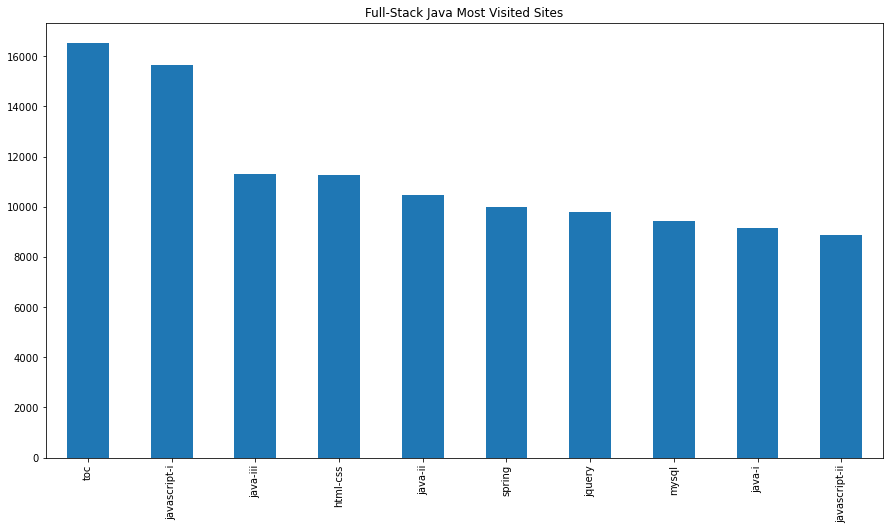

In [10]:
df_dw[df_dw['program_name'] == 'Java Full Stack Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Full-Stack Java Most Visited Sites', figsize = (15,8));

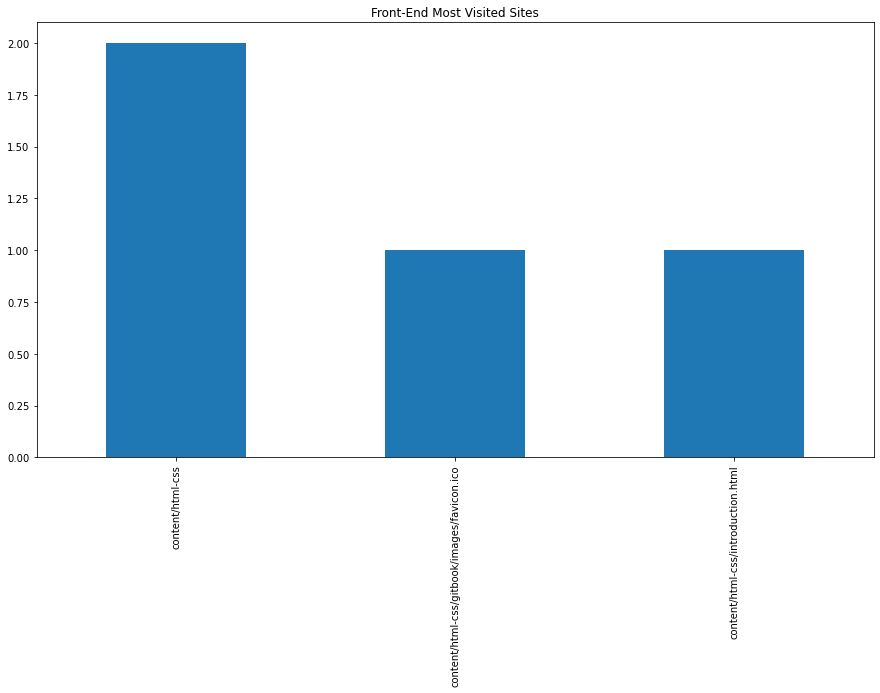

In [11]:
df_dw[df_dw['program_name'] == 'Front End Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Front-End Most Visited Sites', figsize = (15,8));

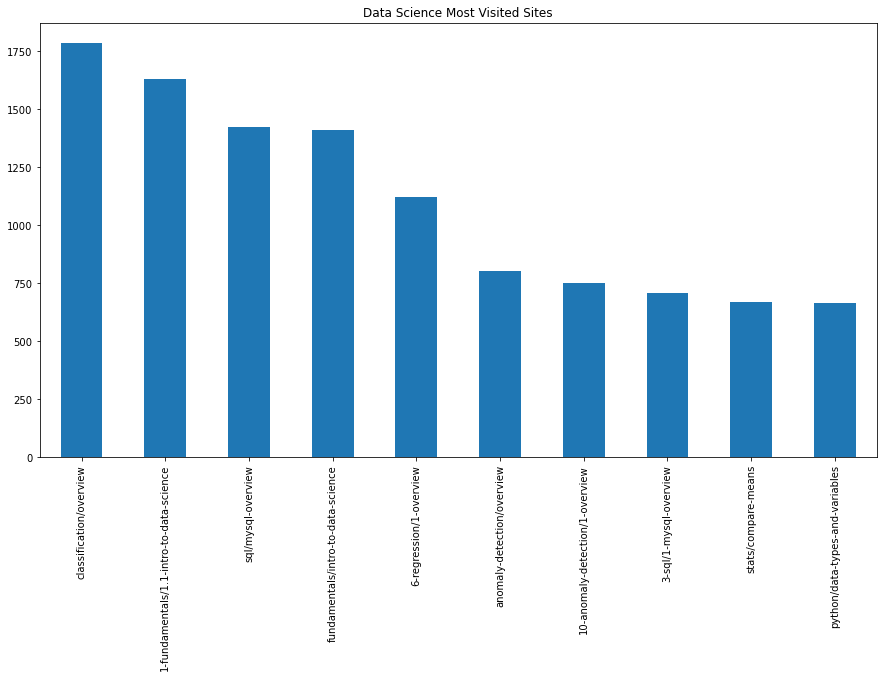

In [12]:
df_dw[df_dw['program_name'] == 'Data Science'].endpoint.value_counts().head(10).plot.bar(title = 'Data Science Most Visited Sites', figsize = (15,8));

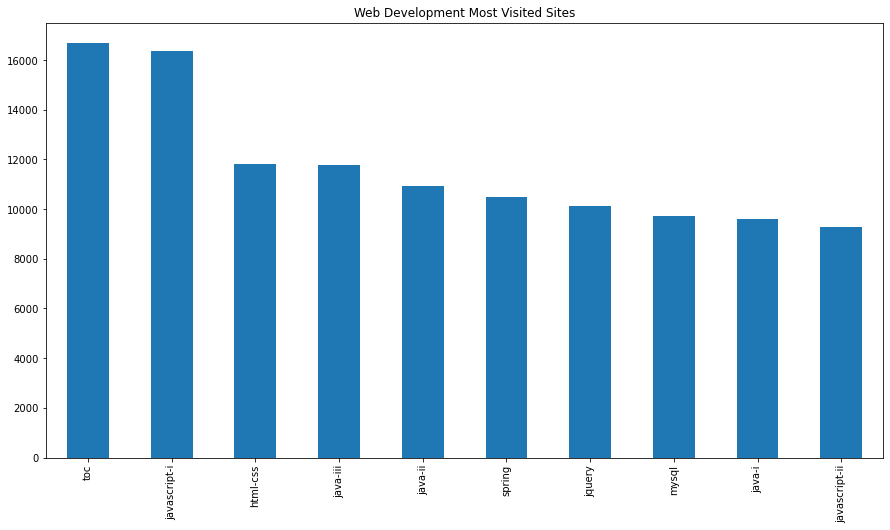

In [13]:
df_dw[df_dw['course'] == 'Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Web Development Most Visited Sites', figsize = (15,8));

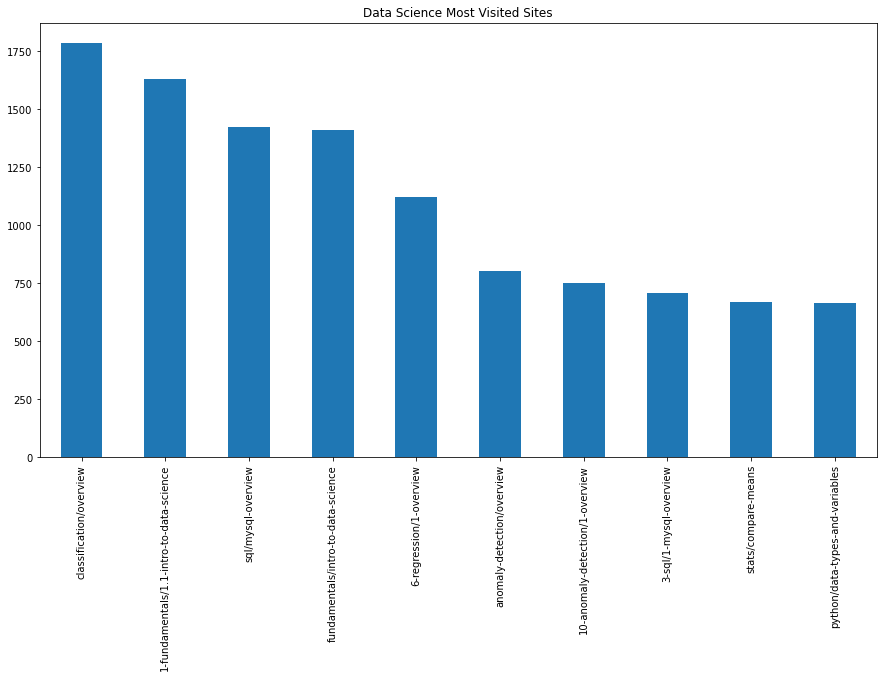

In [14]:
df_dw[df_dw['course'] == 'Data Science'].endpoint.value_counts().head(10).plot.bar(title = 'Data Science Most Visited Sites', figsize = (15,8));

2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

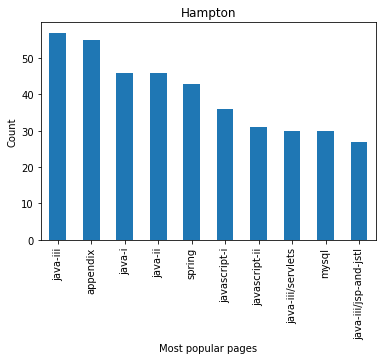

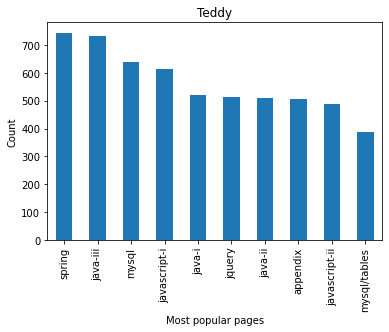

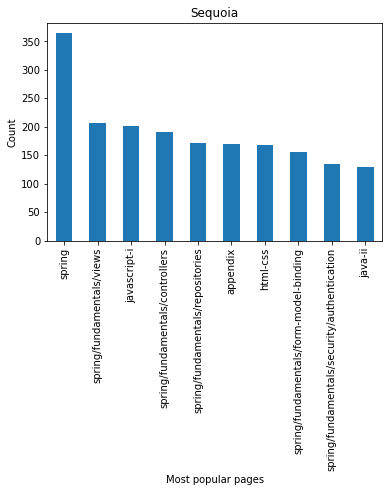

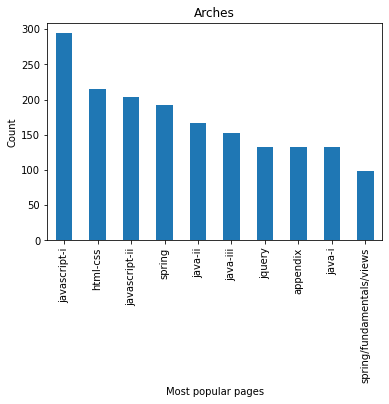

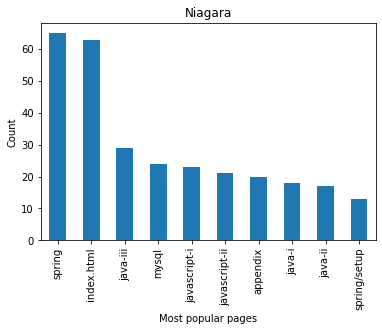

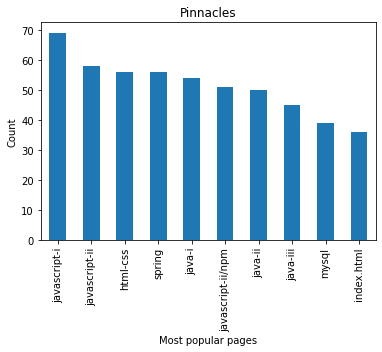

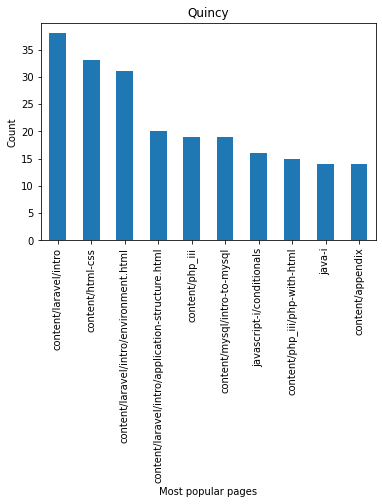

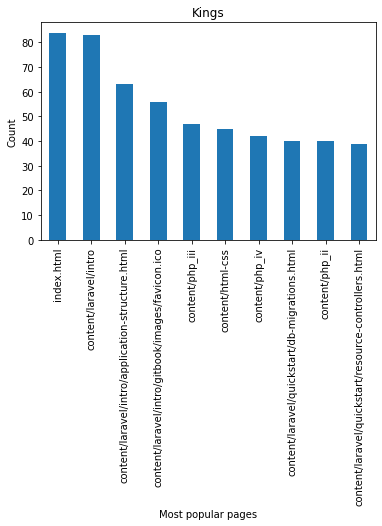

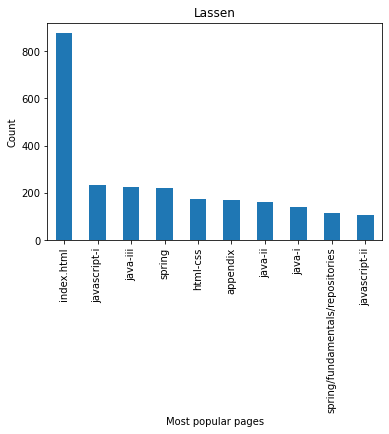

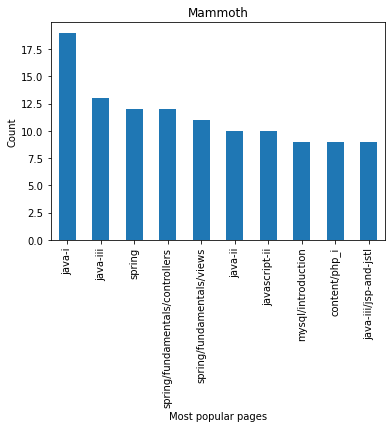

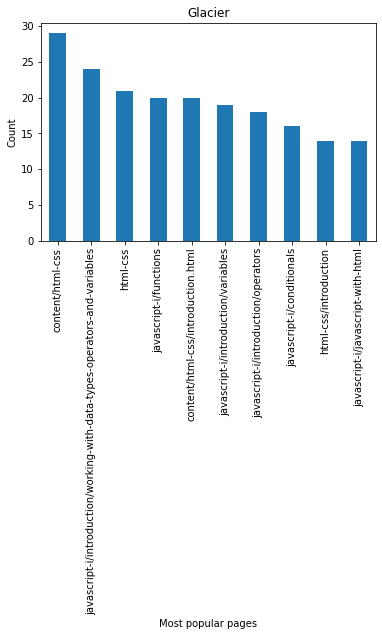

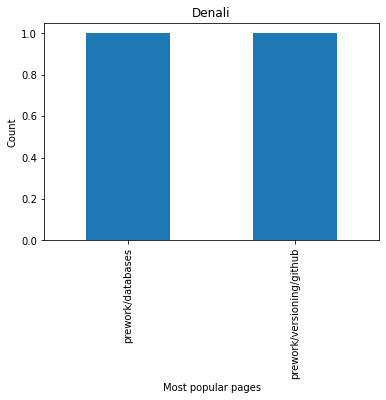

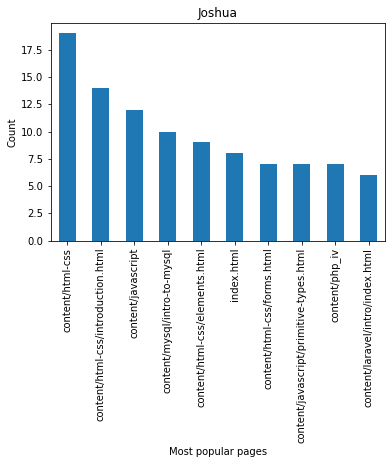

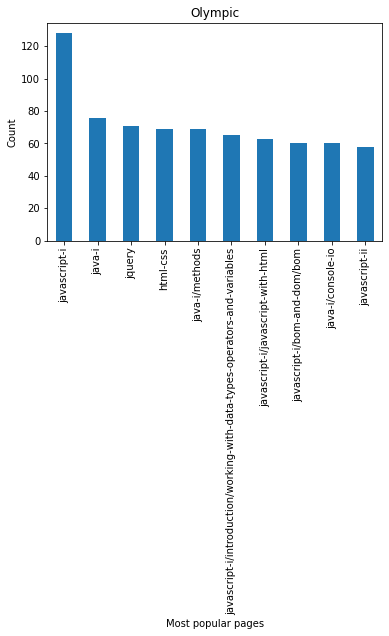

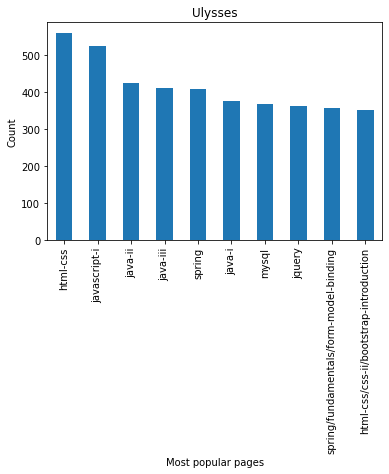

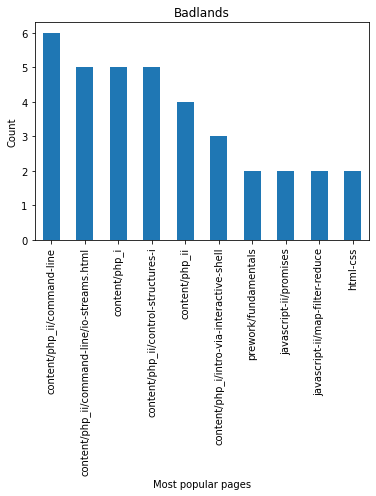

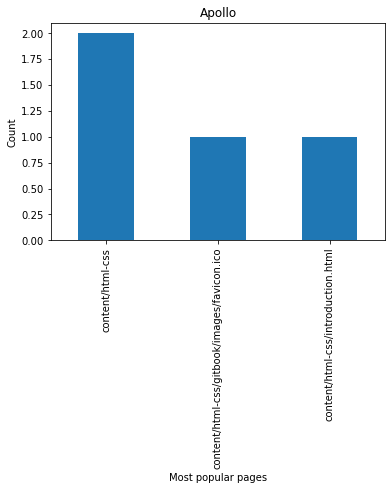

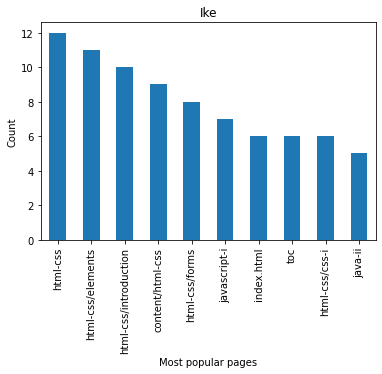

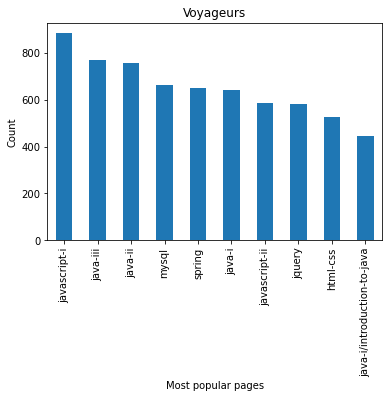

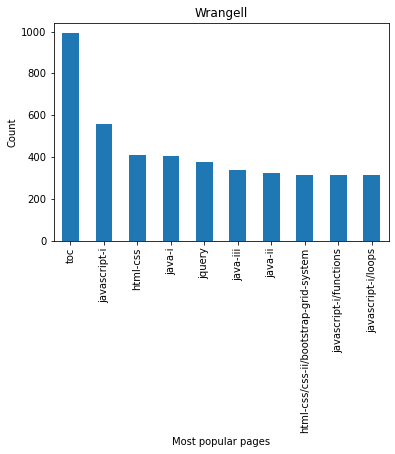

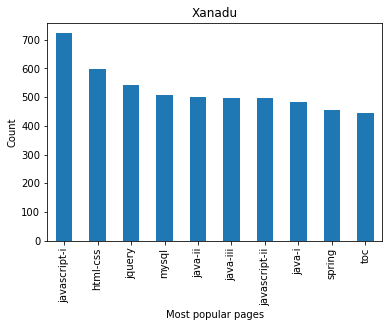

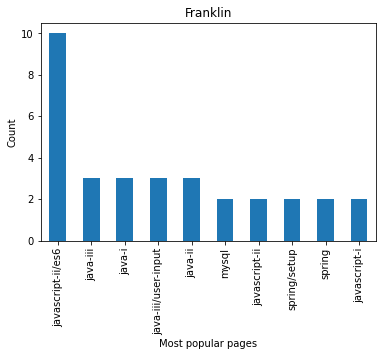

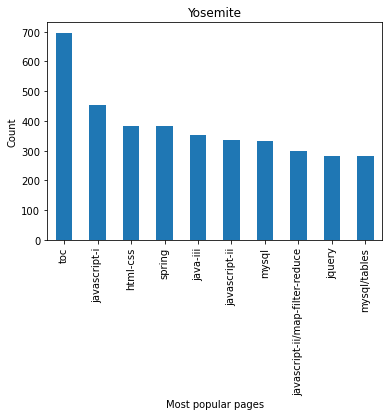

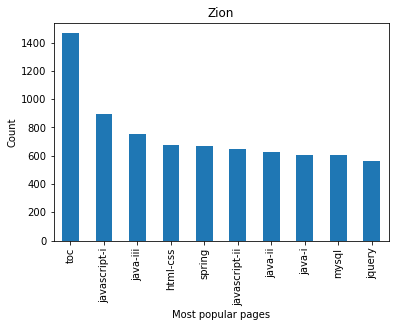

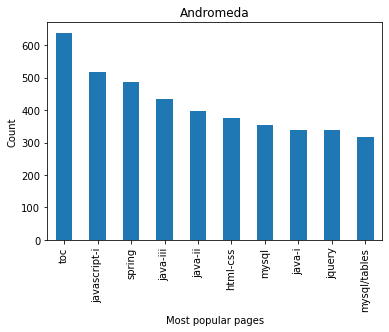

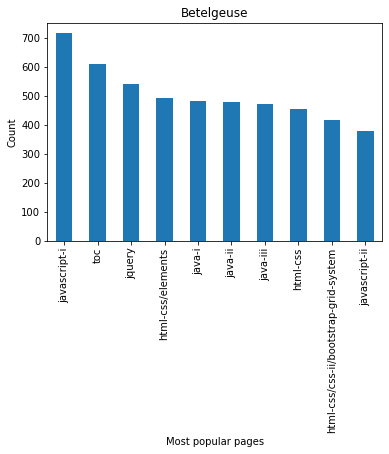

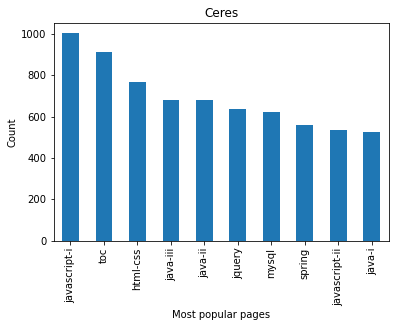

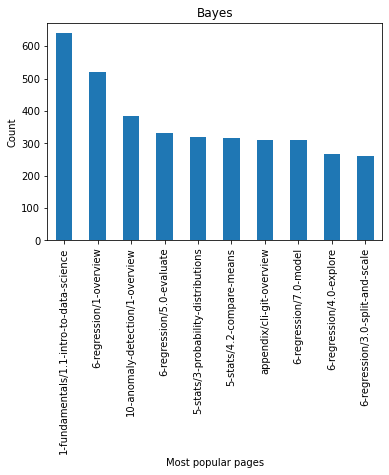

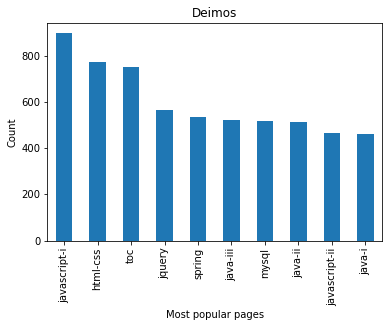

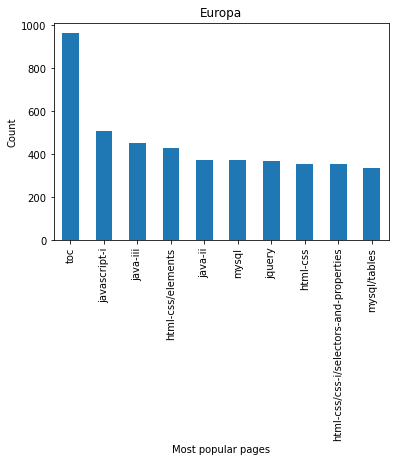

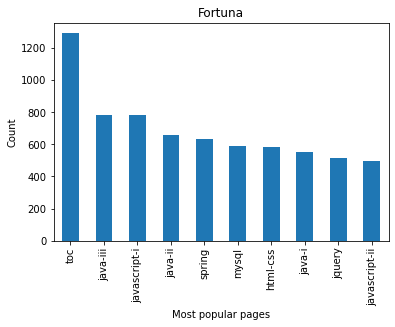

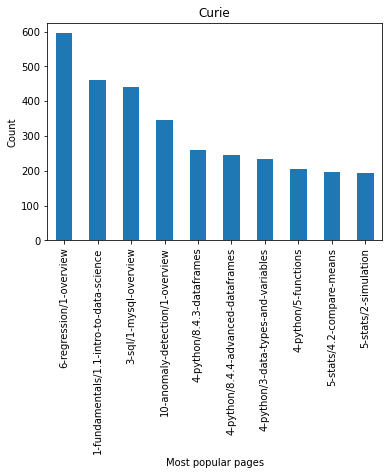

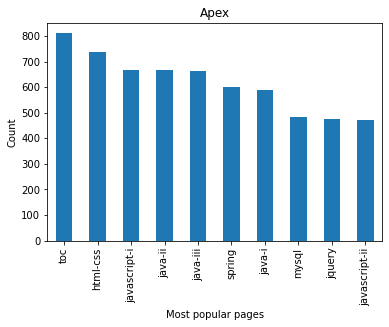

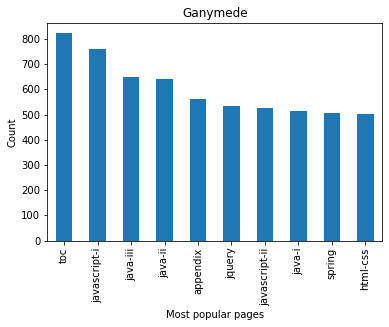

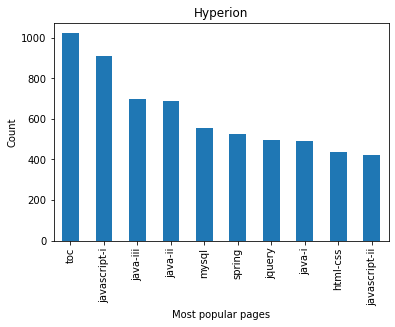

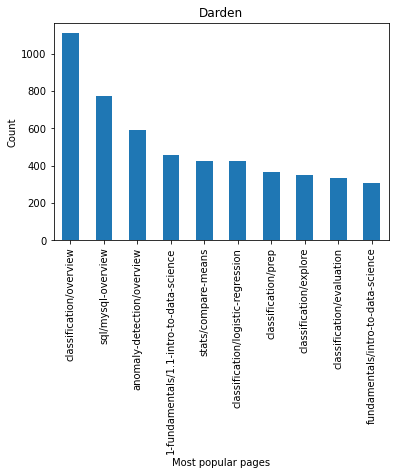

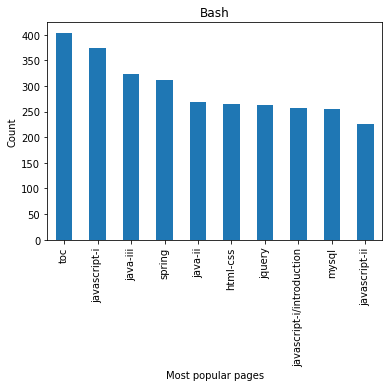

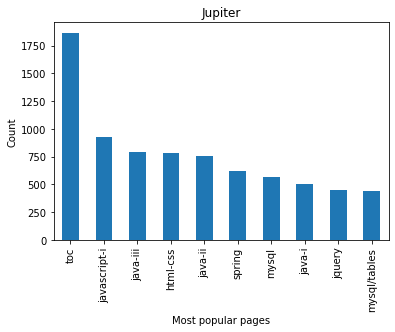

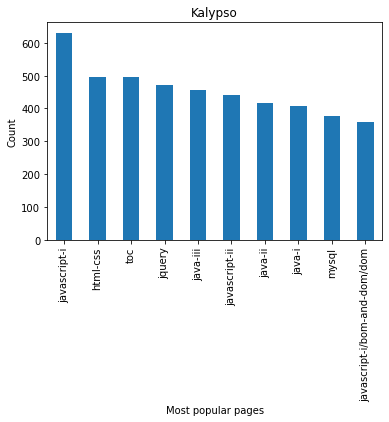

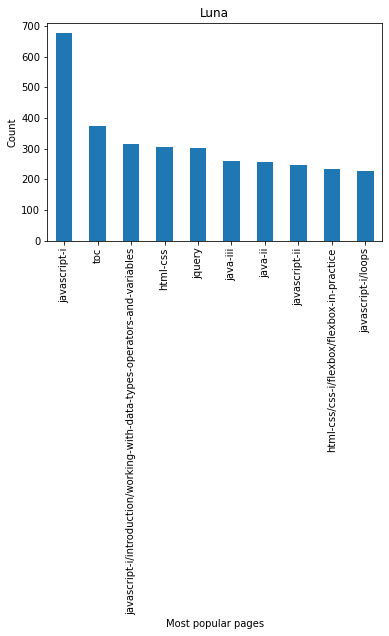

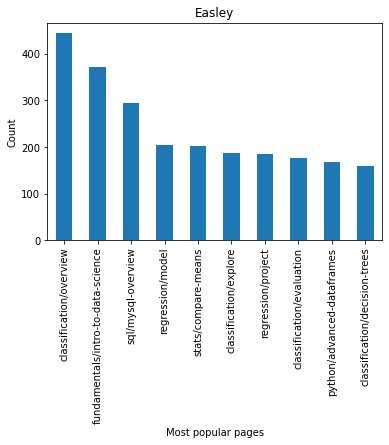

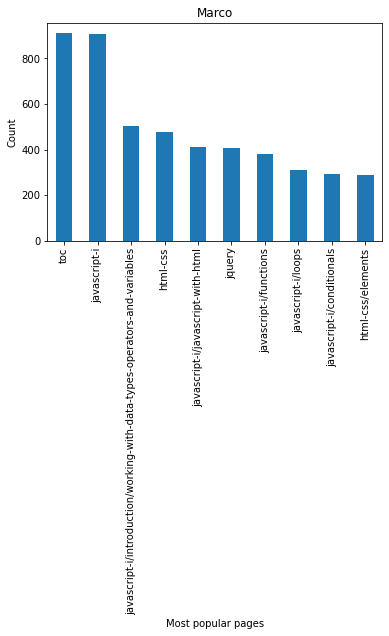

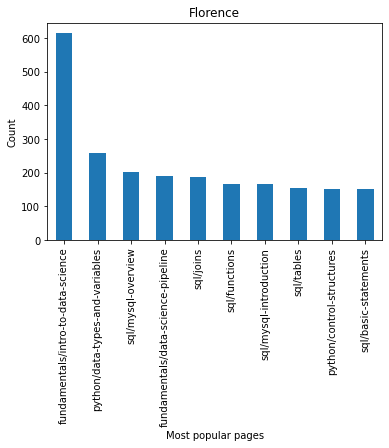

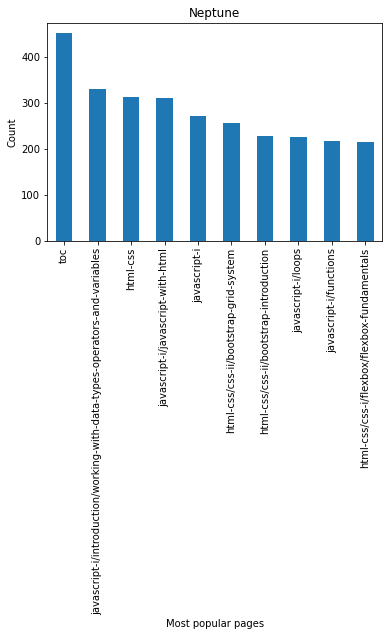

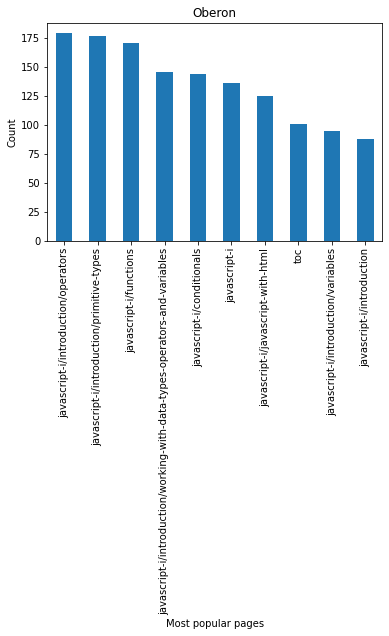

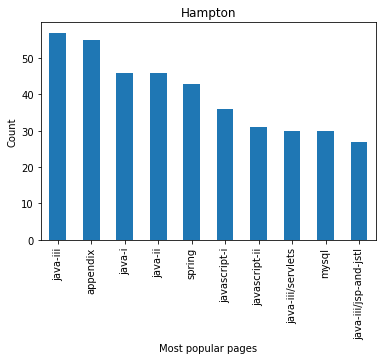

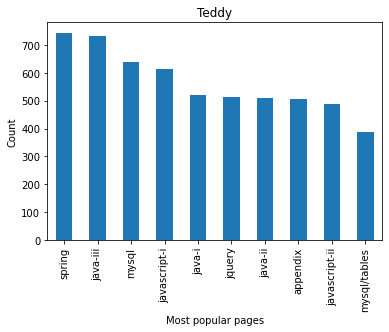

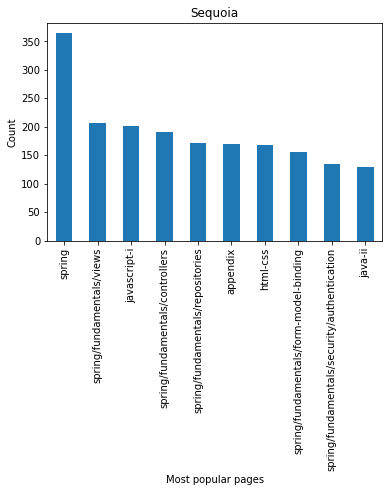

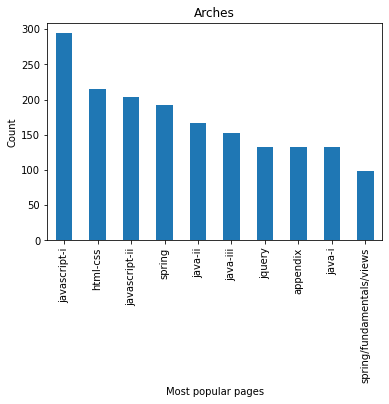

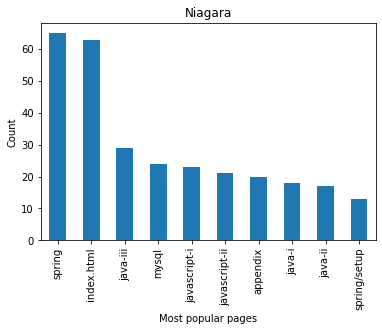

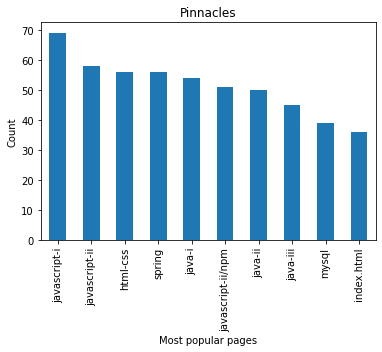

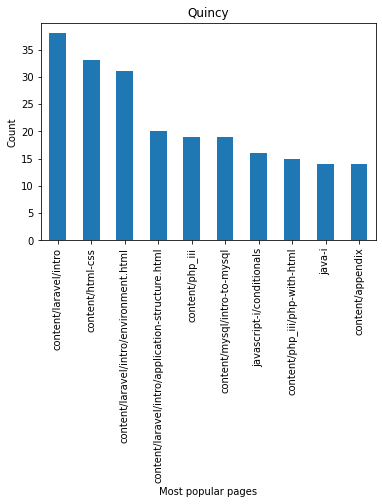

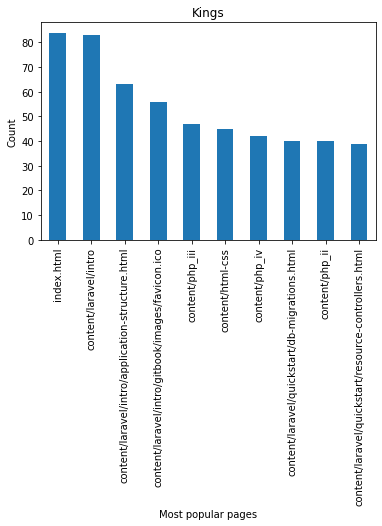

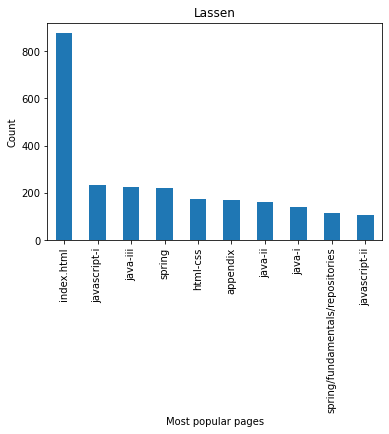

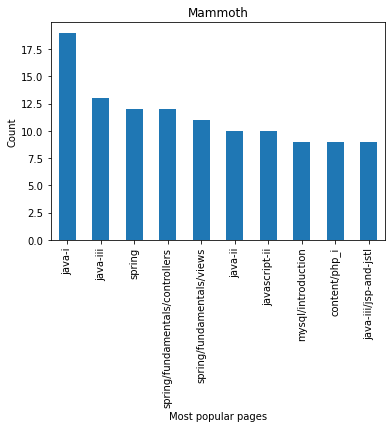

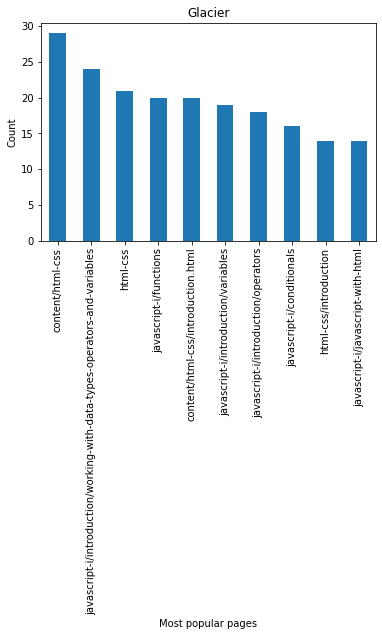

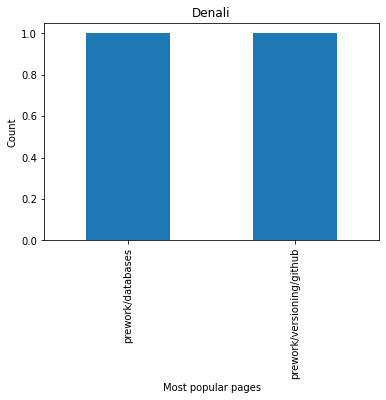

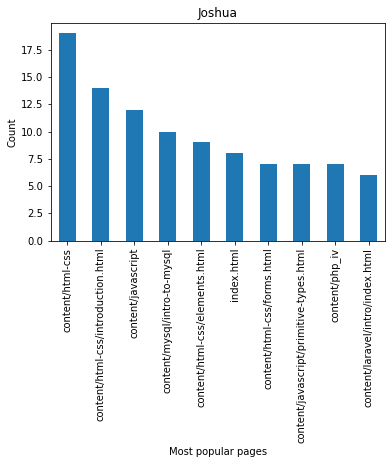

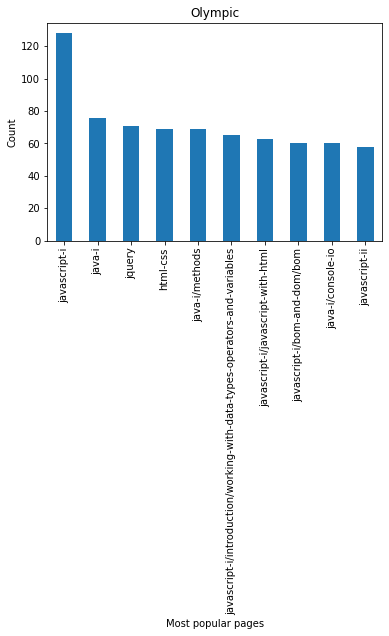

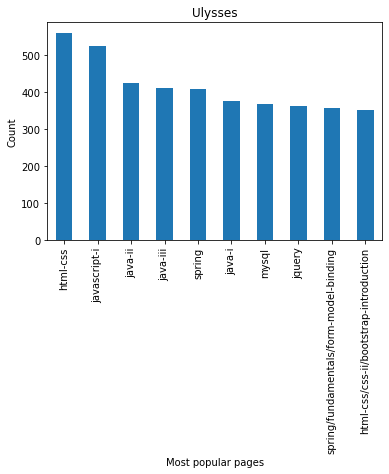

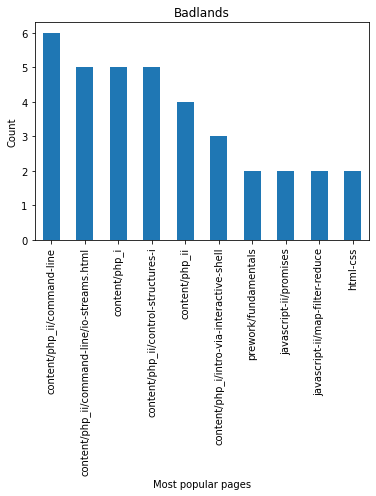

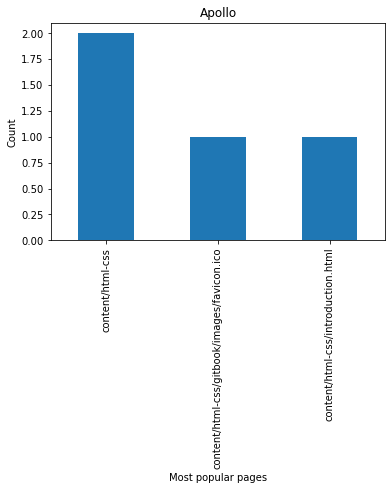

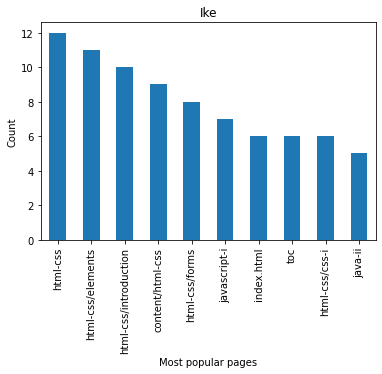

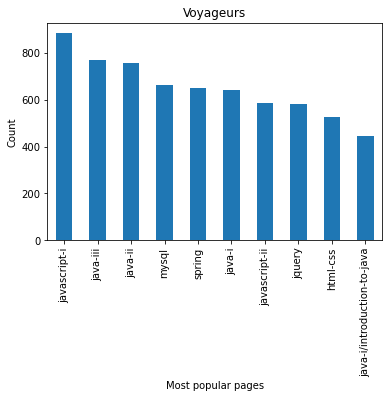

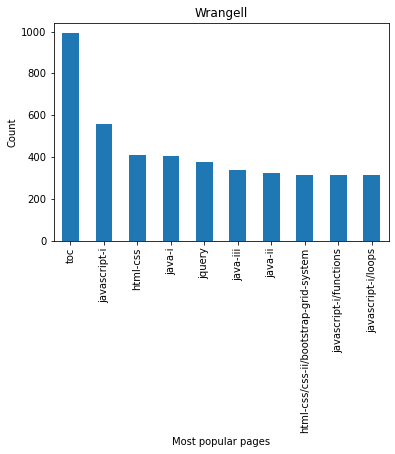

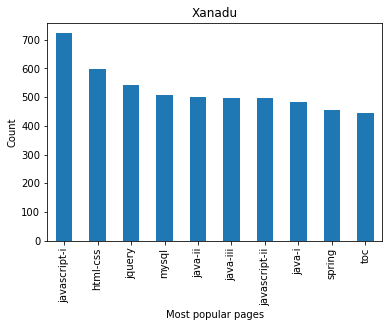

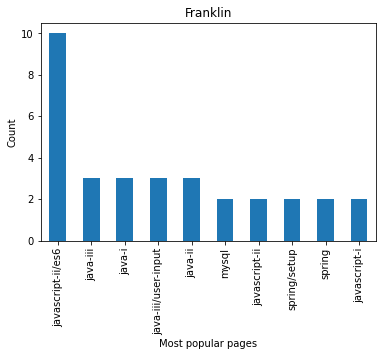

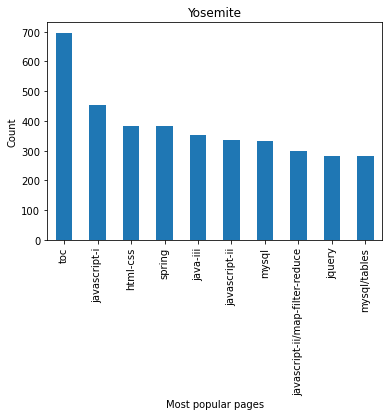

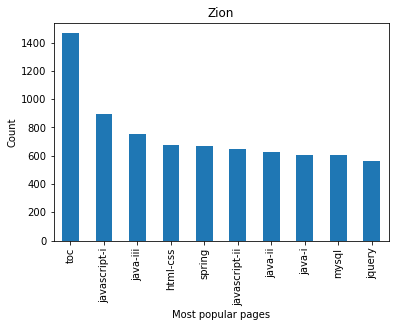

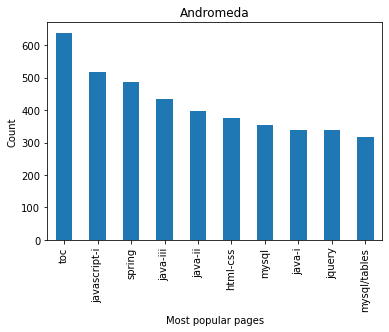

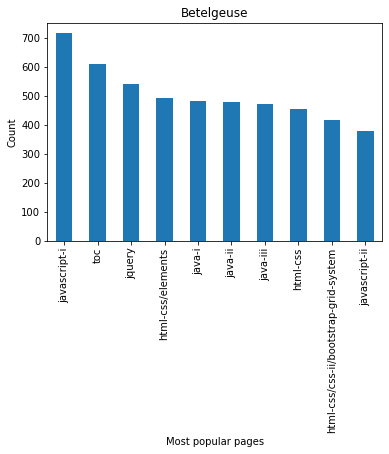

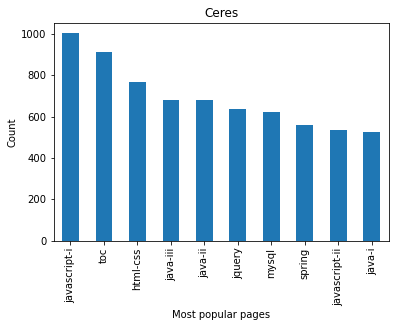

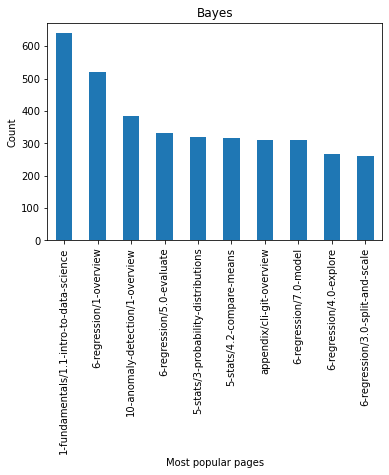

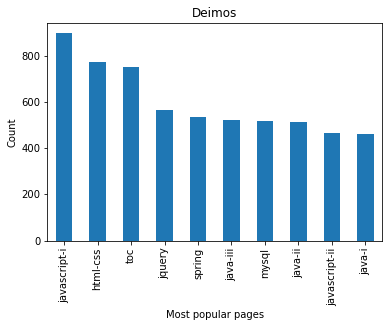

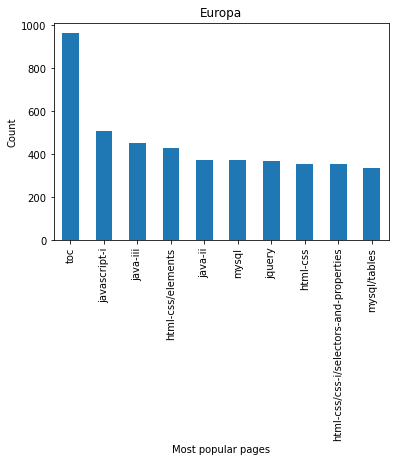

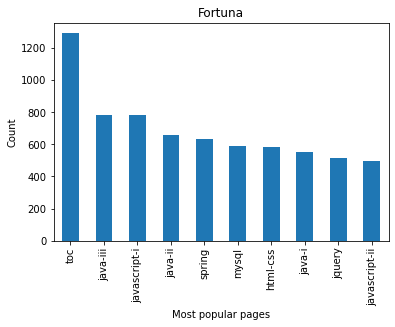

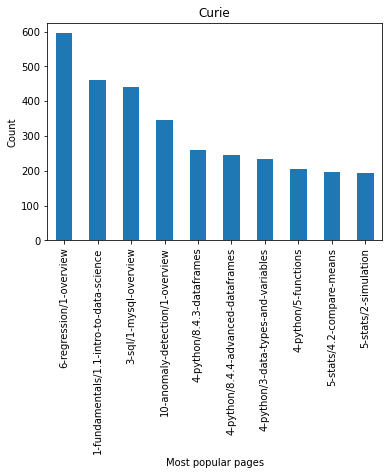

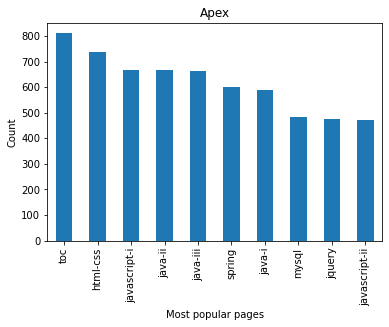

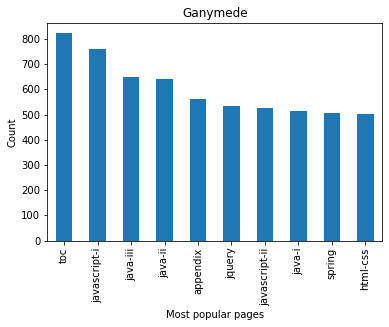

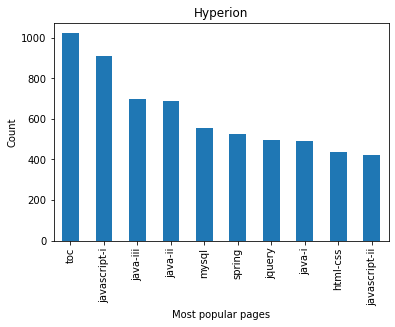

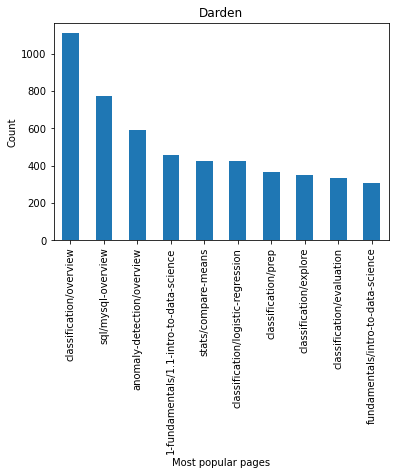

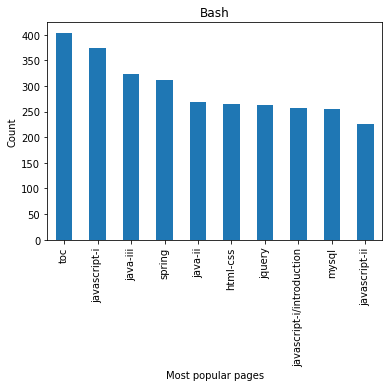

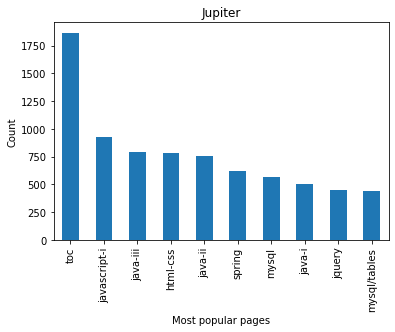

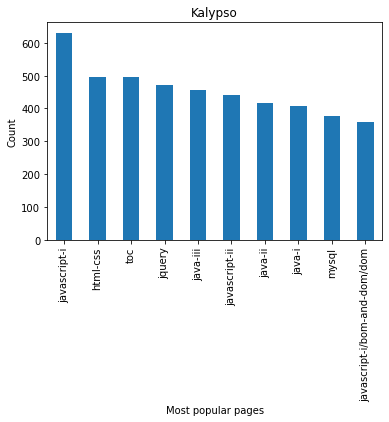

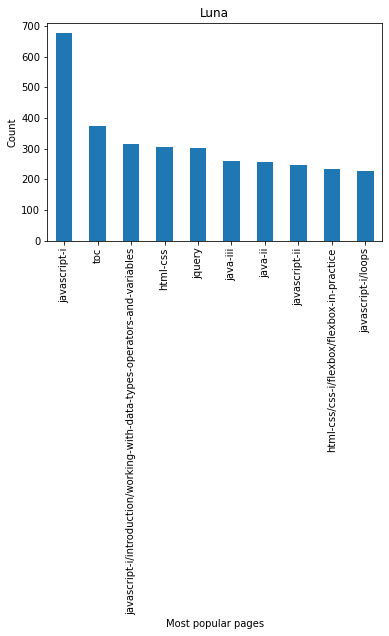

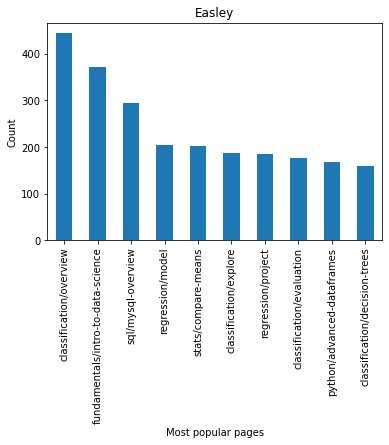

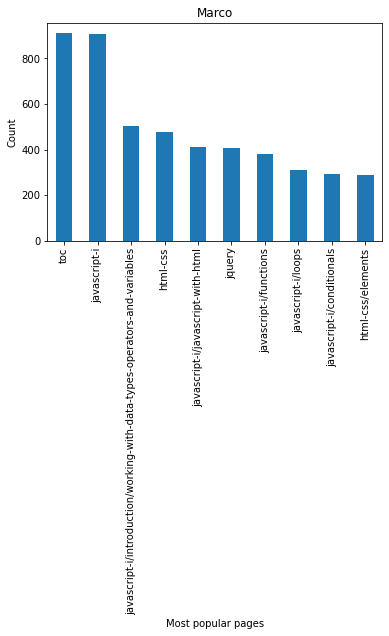

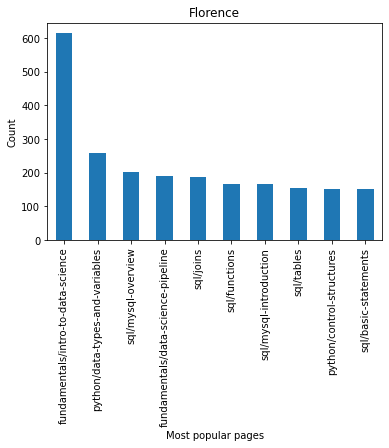

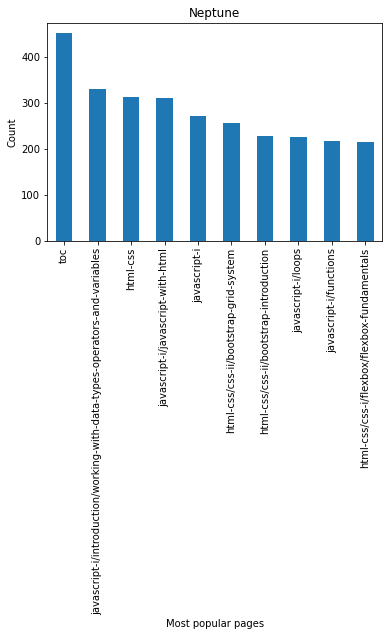

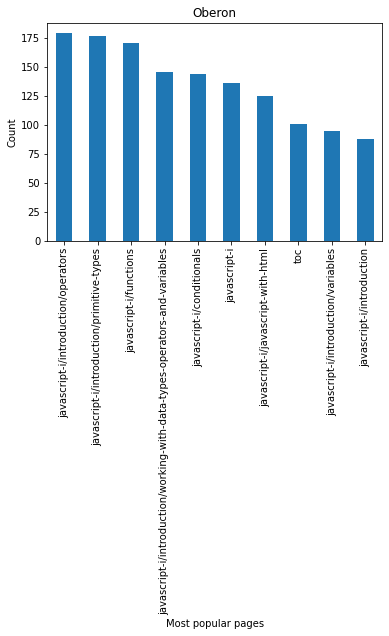

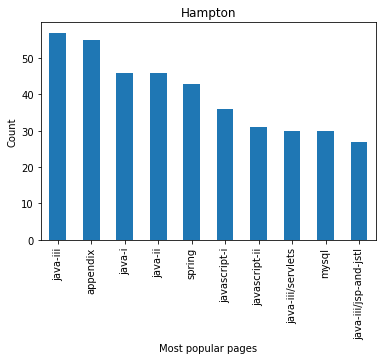

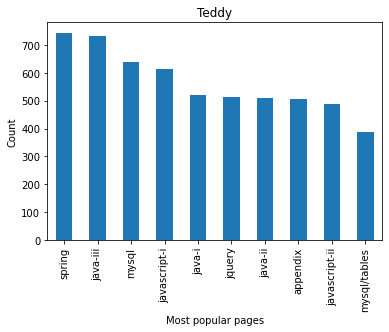

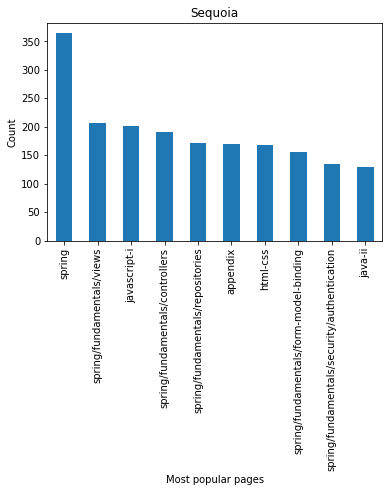

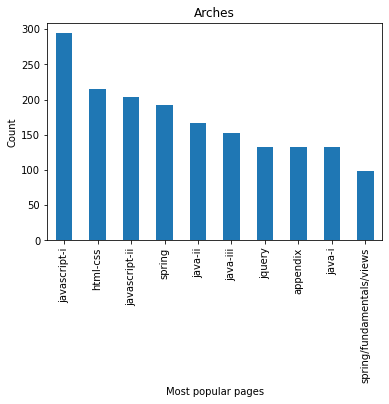

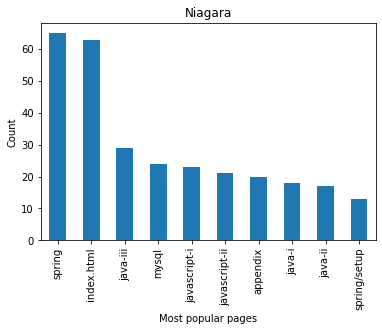

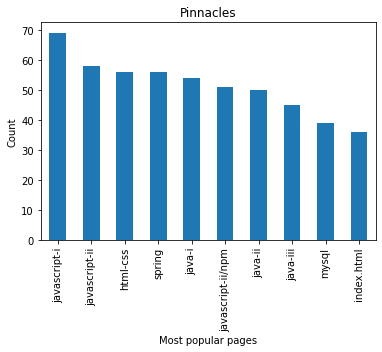

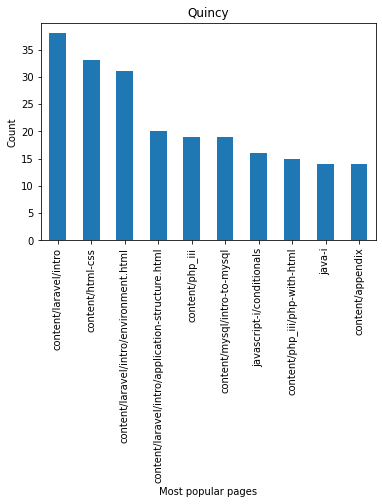

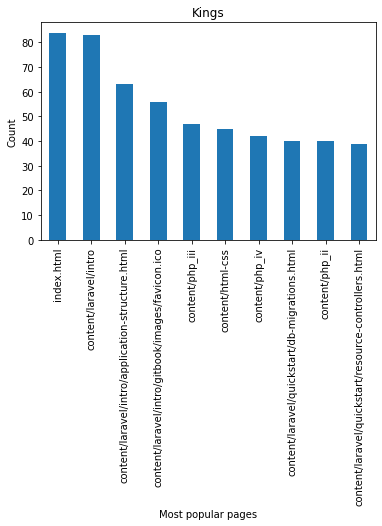

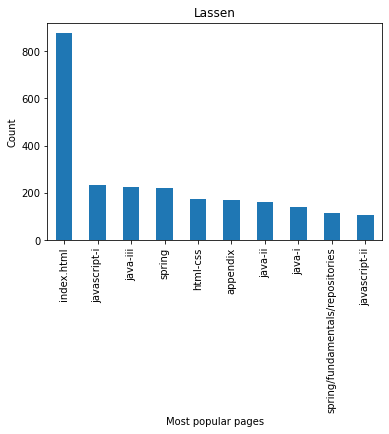

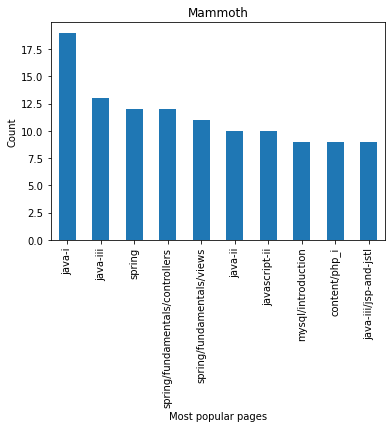

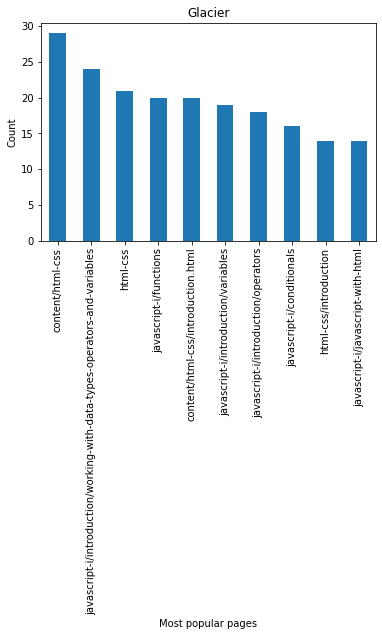

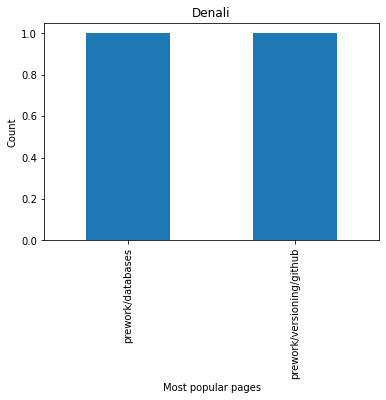

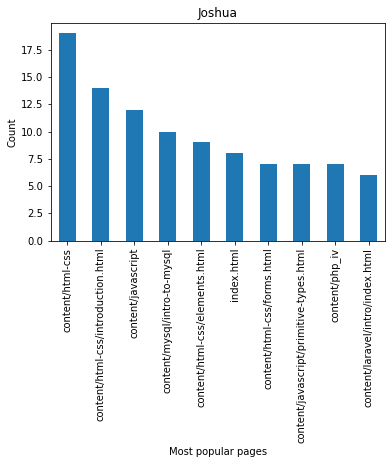

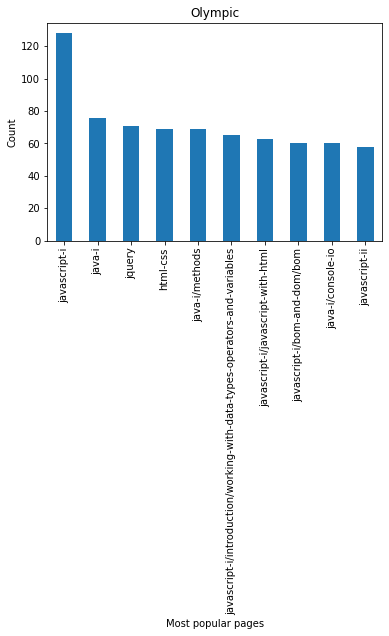

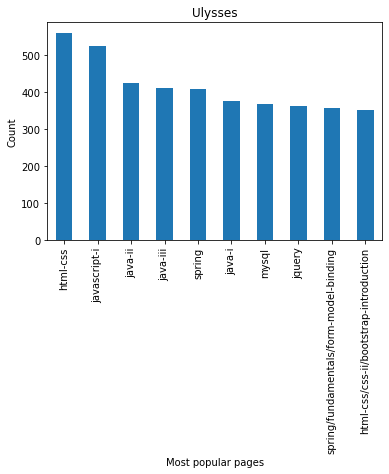

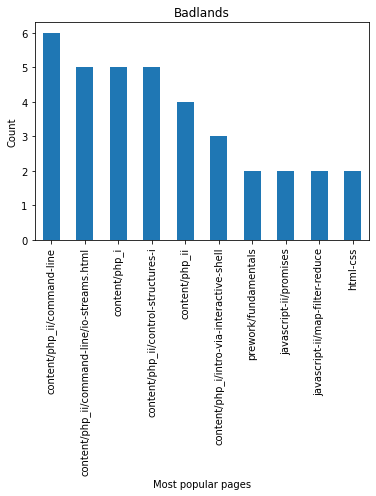

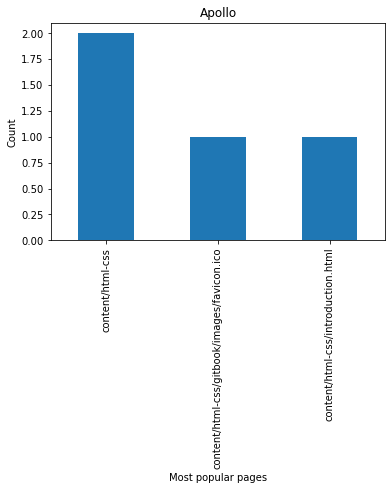

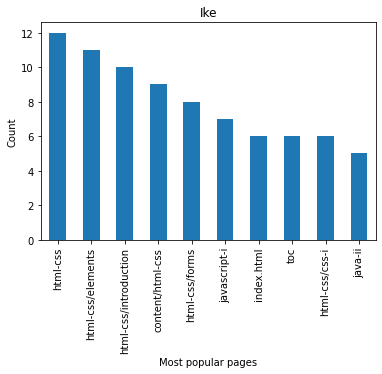

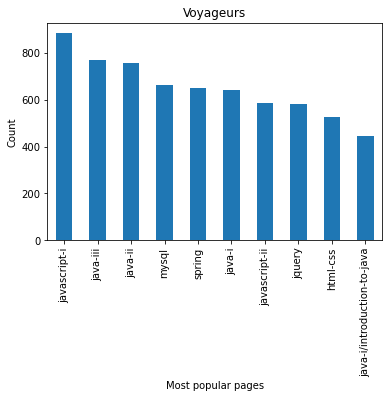

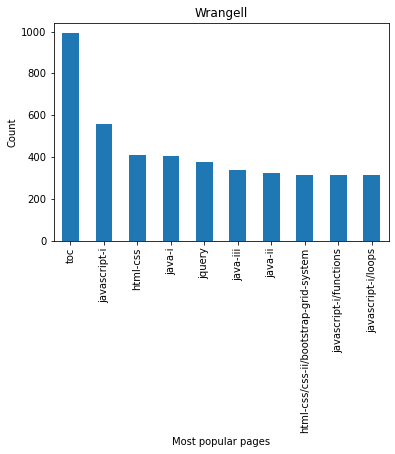

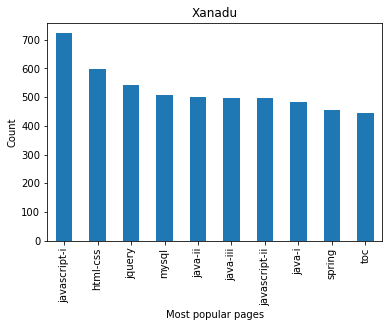

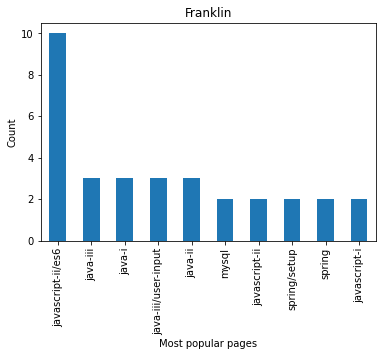

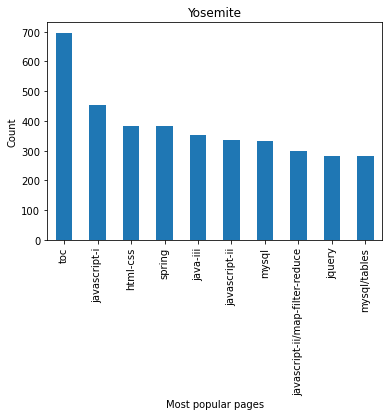

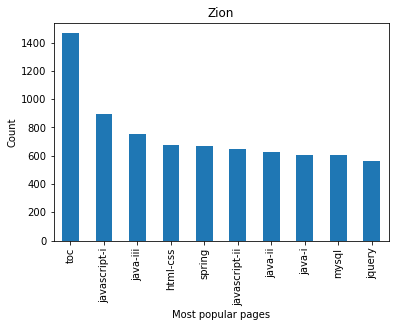

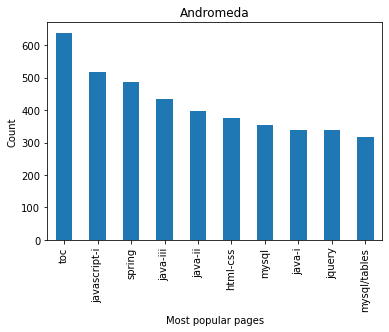

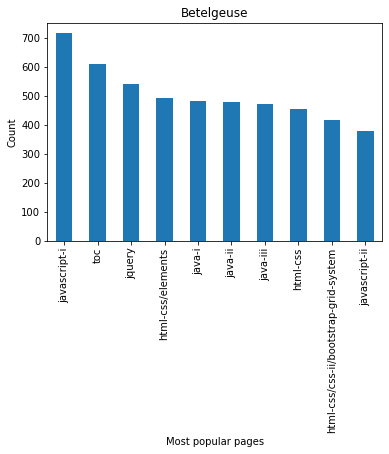

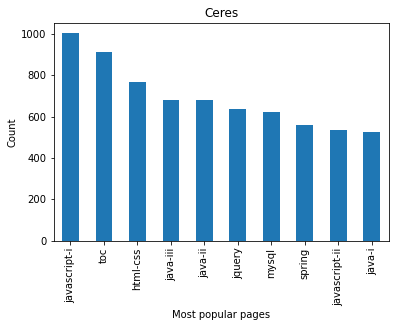

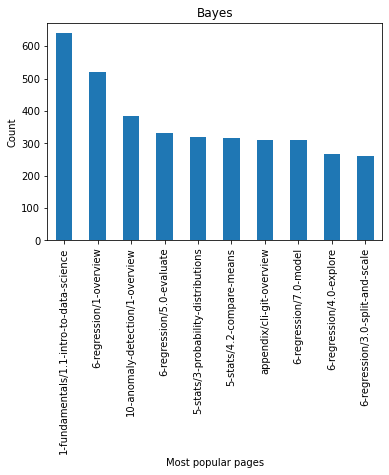

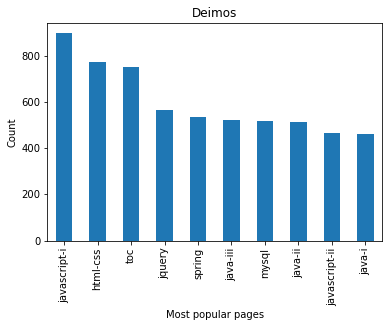

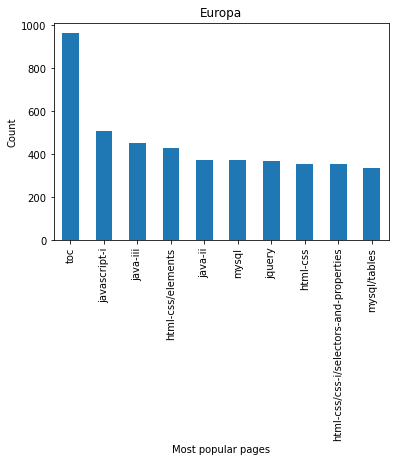

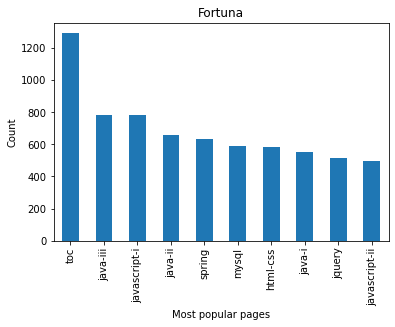

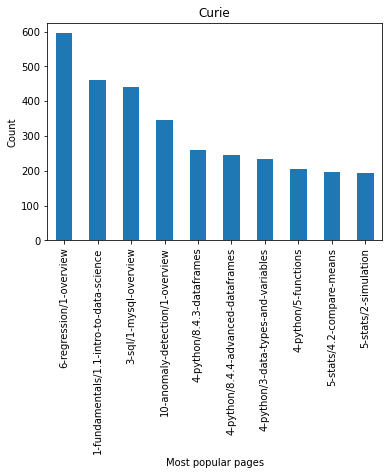

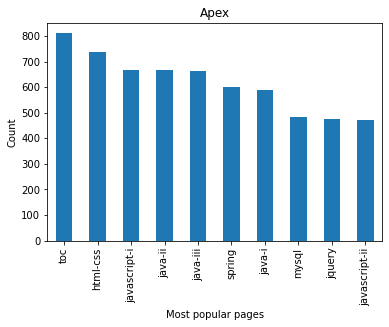

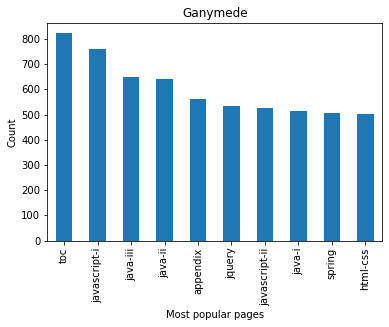

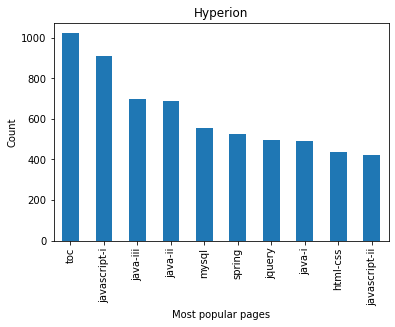

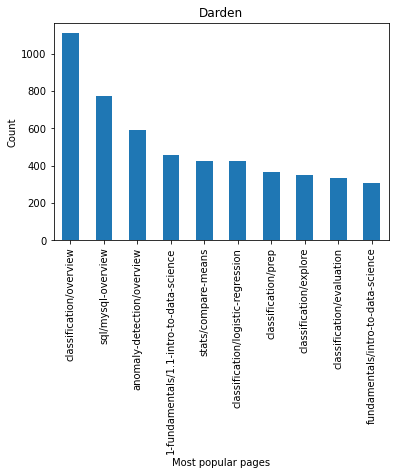

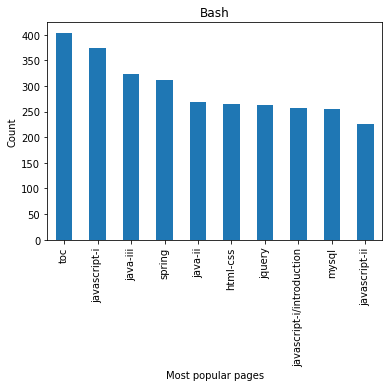

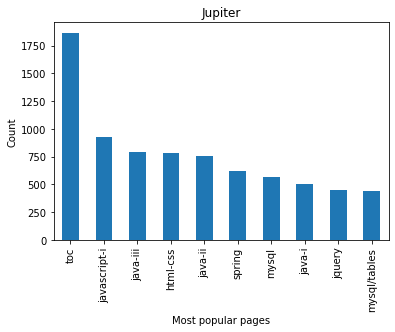

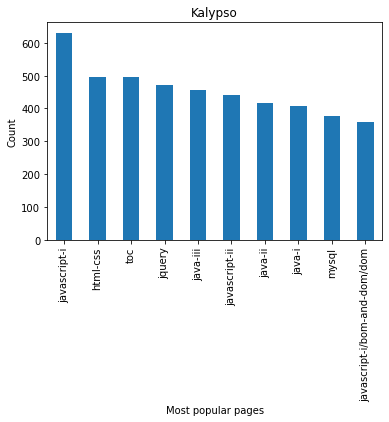

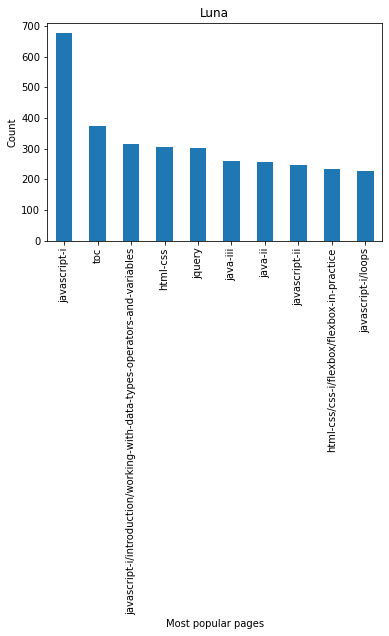

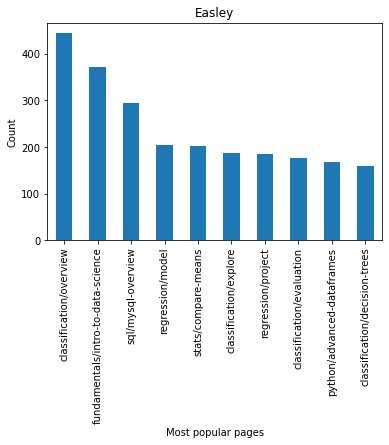

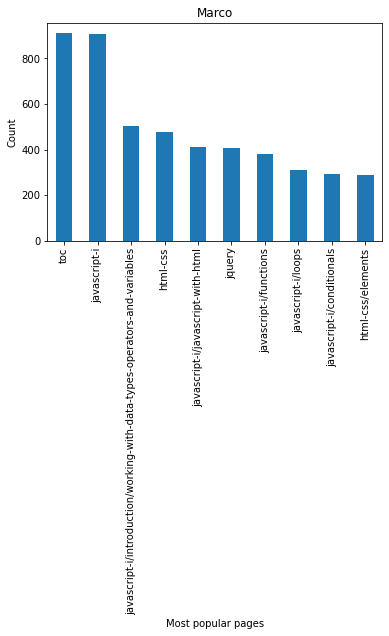

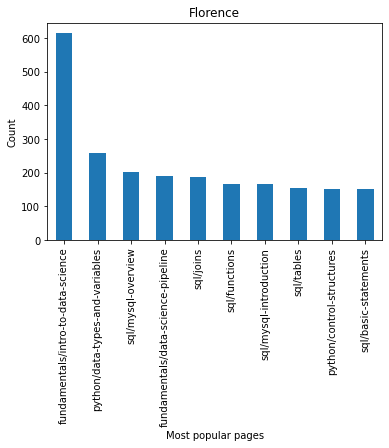

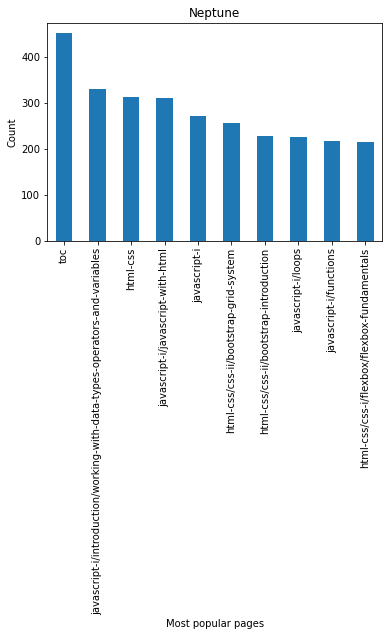

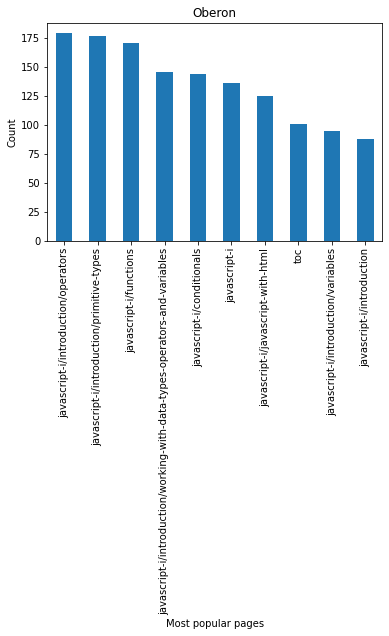

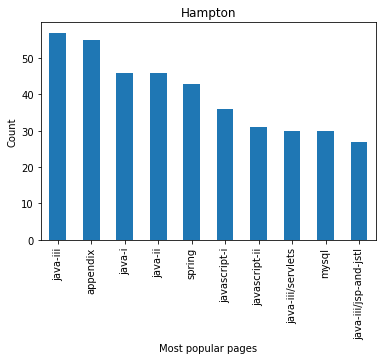

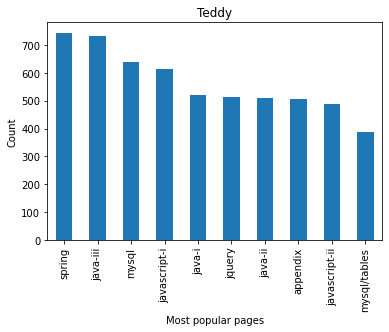

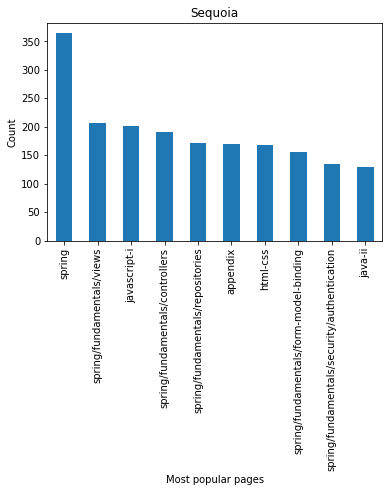

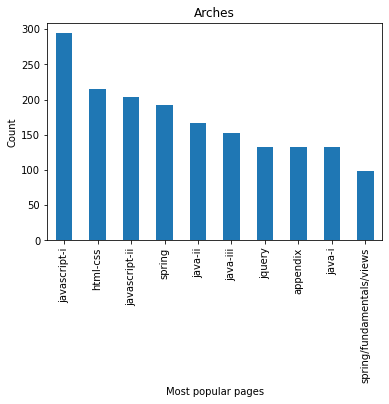

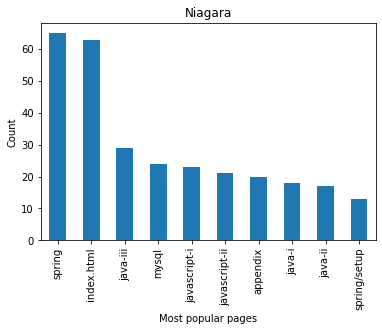

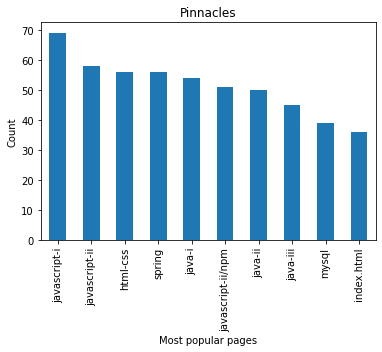

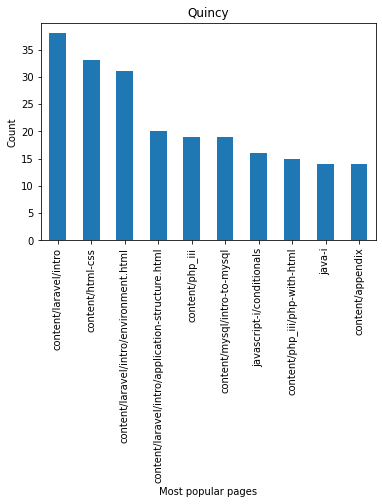

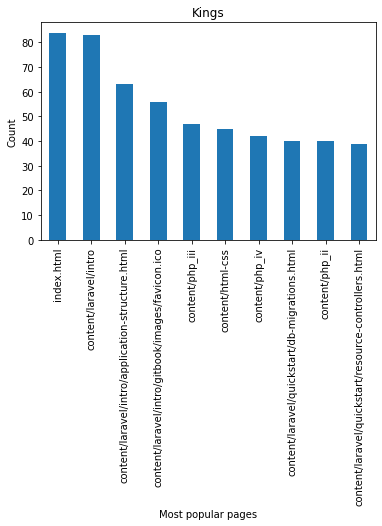

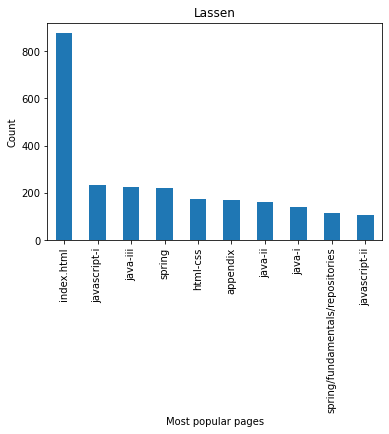

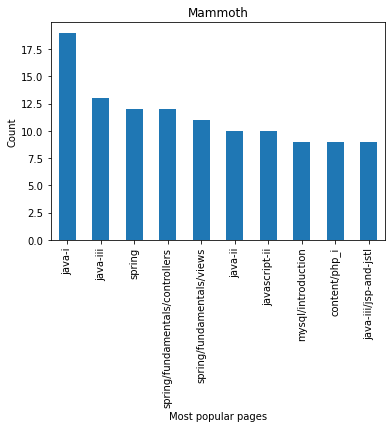

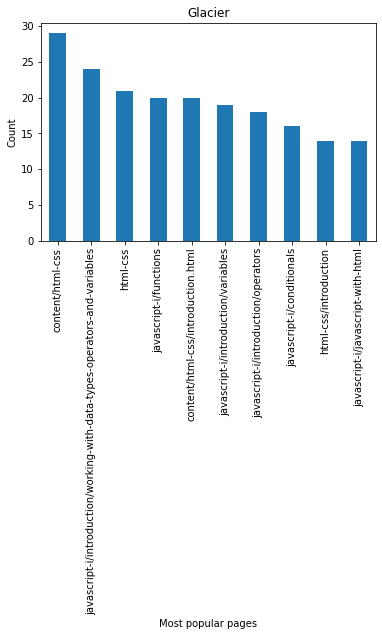

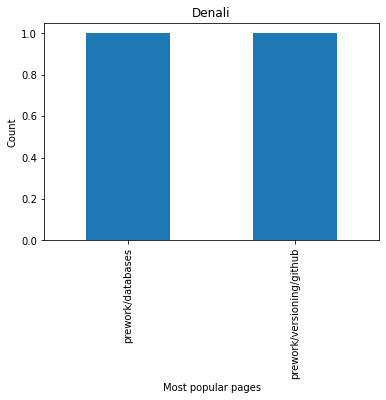

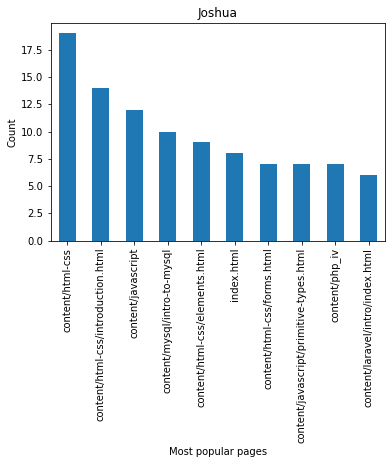

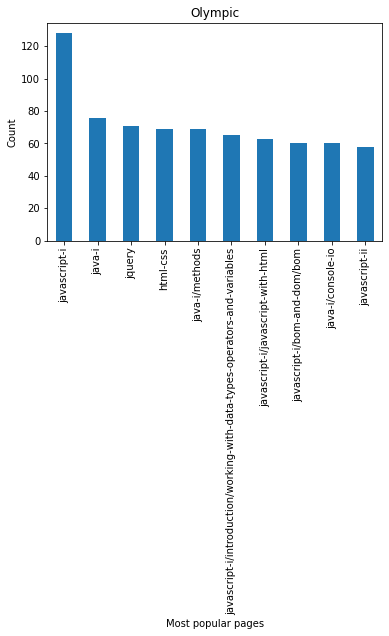

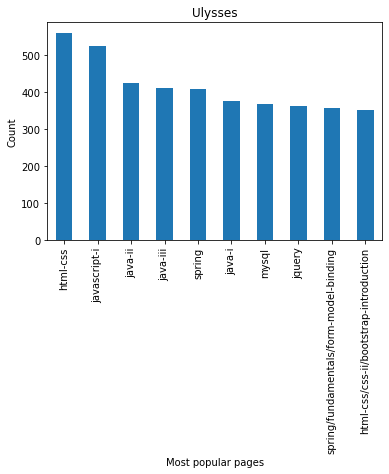

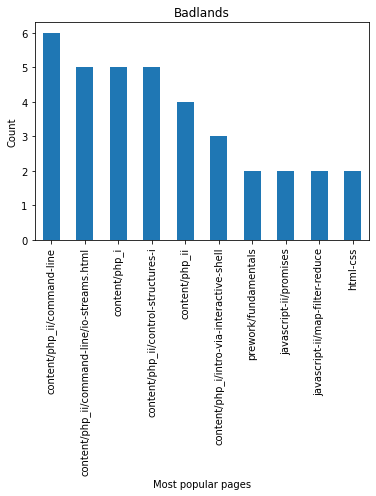

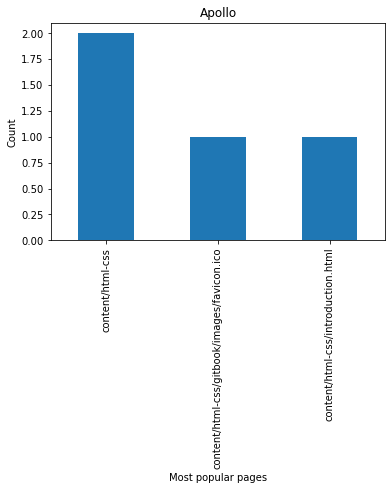

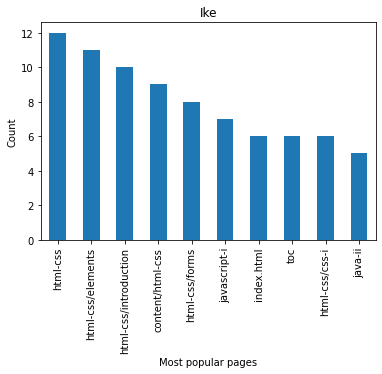

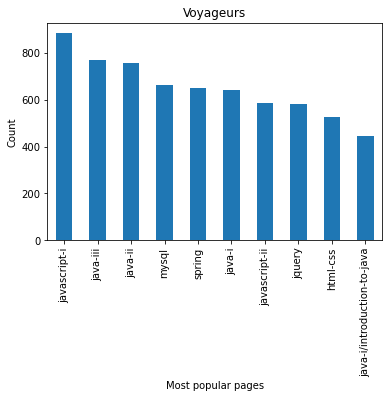

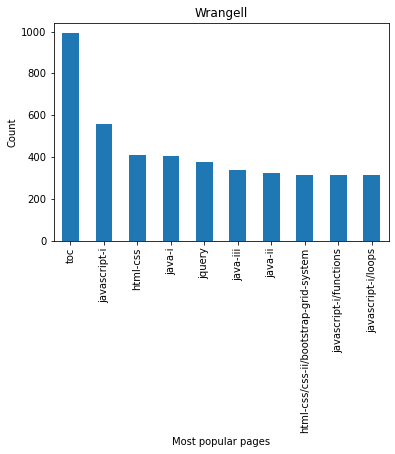

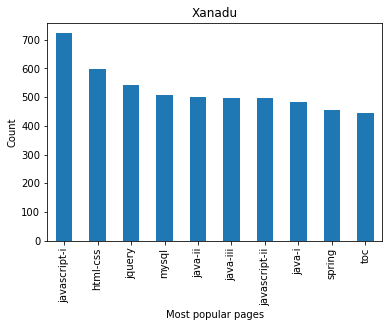

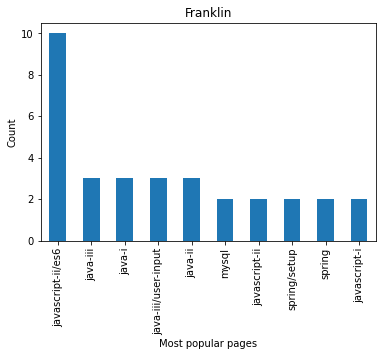

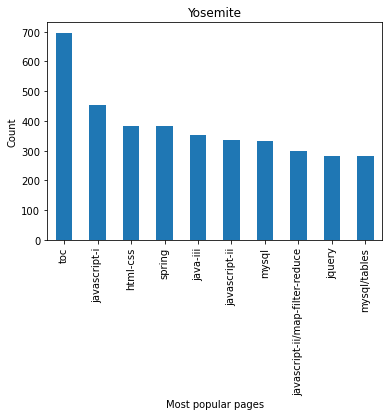

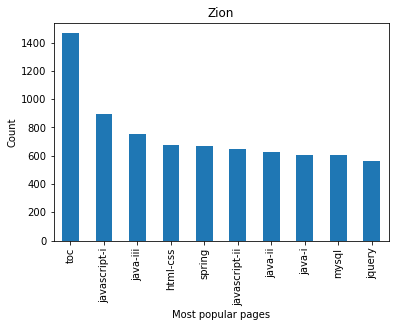

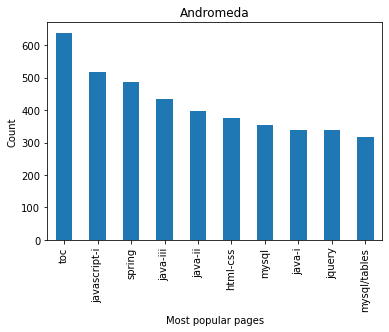

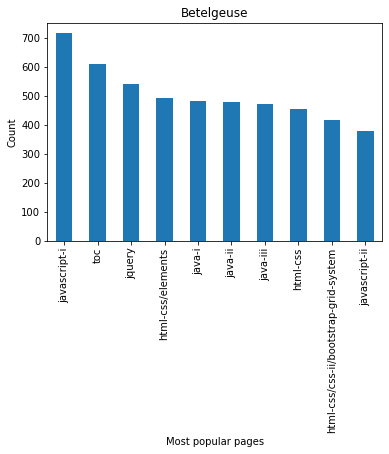

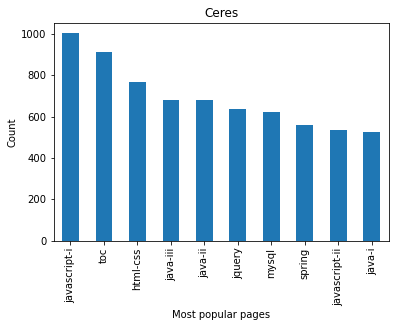

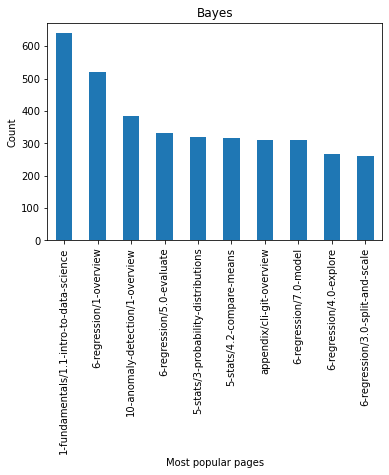

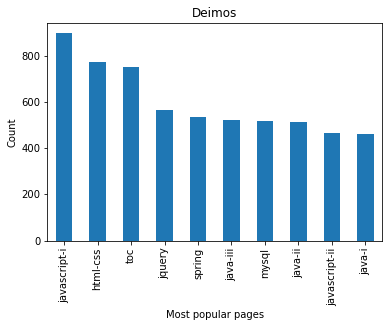

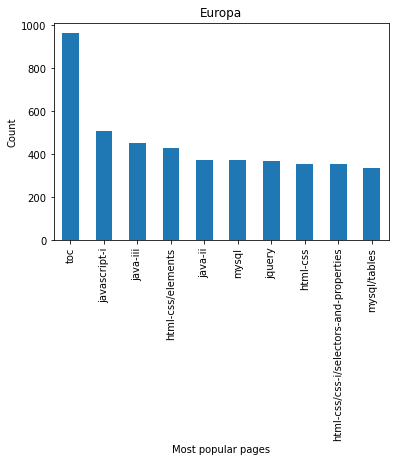

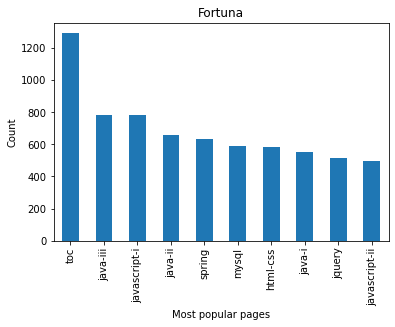

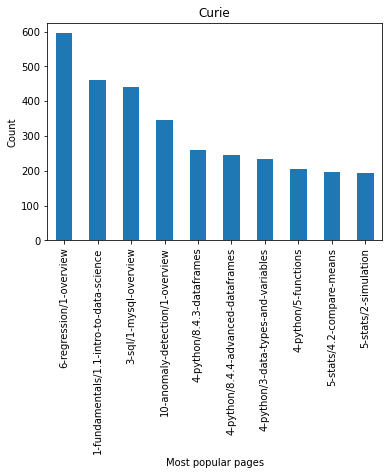

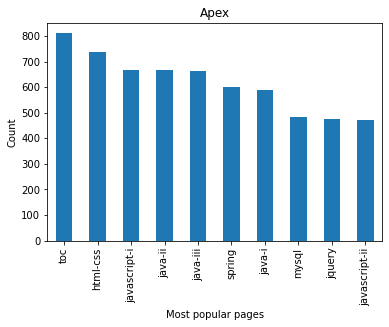

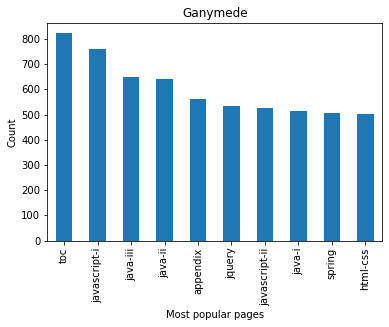

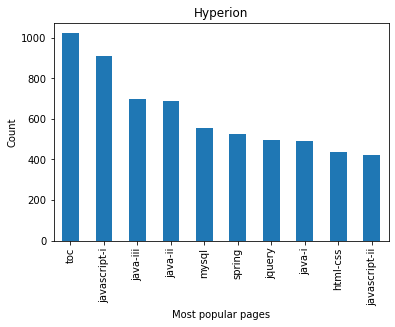

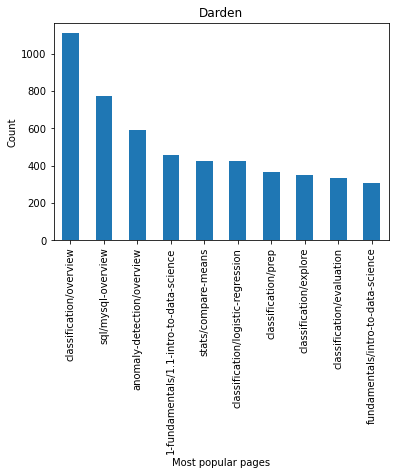

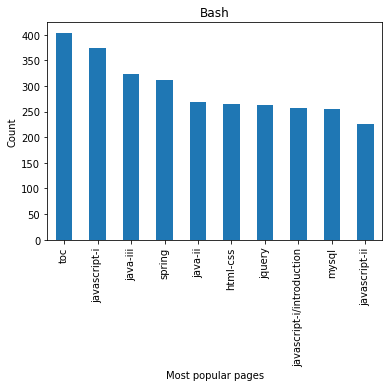

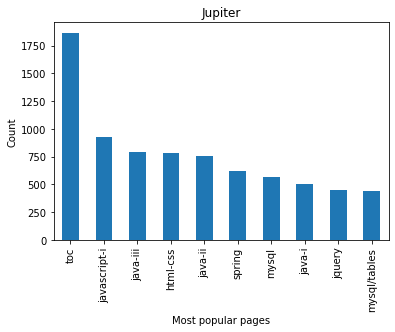

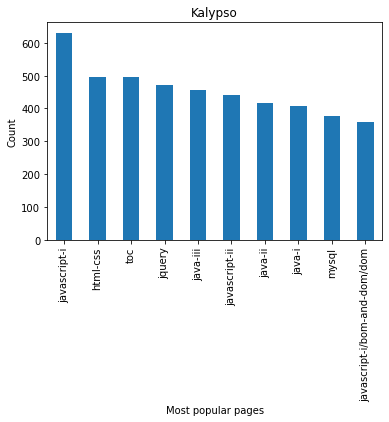

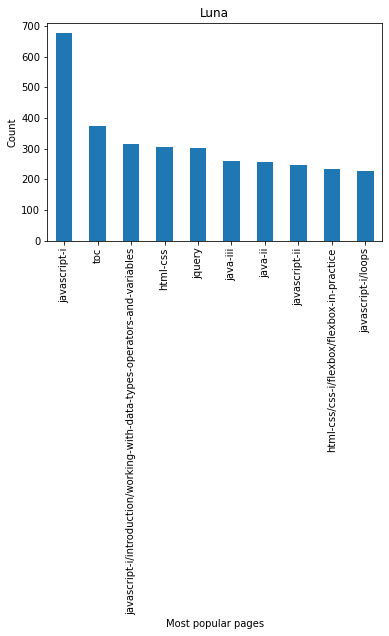

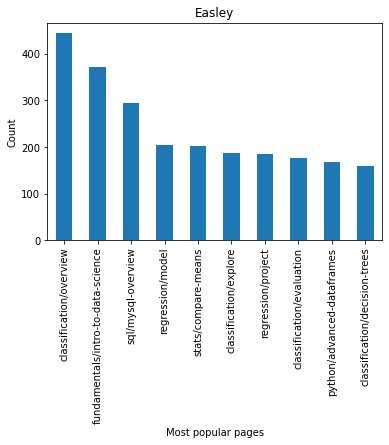

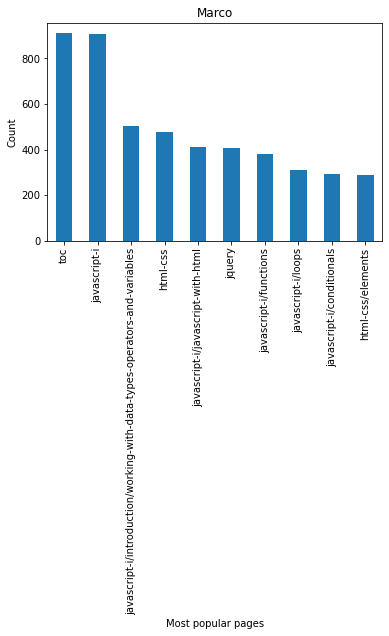

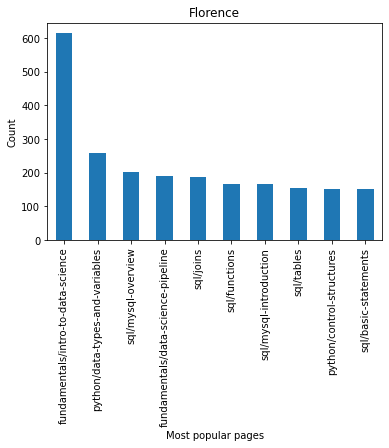

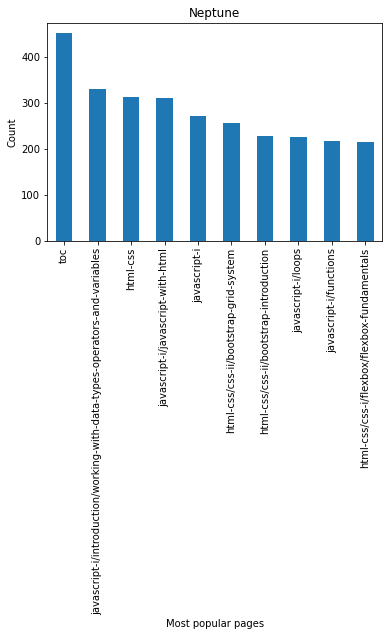

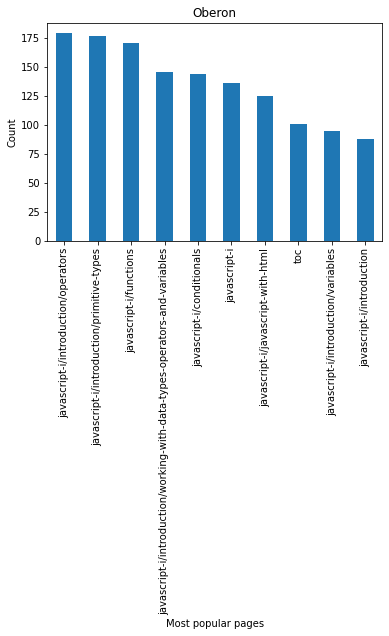

In [15]:
for program in df_dw.program_name.unique():
    plt.title(program)
    for cohort in df_dw.cohort_name.unique():
        plt.title(cohort)
        df_dw[df_dw['cohort_name'] == cohort].endpoint.value_counts().head(10).plot.bar()
        plt.xlabel('Most popular pages')
        plt.ylabel('Count')
        plt.show();


In [16]:
df_dw[df_dw['cohort_name'] == 'Teddy'].endpoint.value_counts().head(10)

spring           744
java-iii         732
mysql            638
javascript-i     615
java-i           522
jquery           512
java-ii          509
appendix         505
javascript-ii    487
mysql/tables     387
Name: endpoint, dtype: int64

In [17]:
with pd.option_context('display.max_rows', None):
    display(df_dw.groupby('endpoint').cohort_name.value_counts().to_frame())

cohort_name
endpoint                                           cohort_name             
%20https://github.com/RaulCPena                    Curie                  1
,%20https://github.com/RaulCPena                   Curie                  1
.git                                               Voyageurs              1
.gitignore                                         Darden                 1
                                                   Voyageurs              1
00_index                                           Wrangell               2
01_intro                                           Wrangell               2
02_listing_files                                   Wrangell               1
03_file_paths                                      Wrangell               1
04_navigating_the_filesystem                       Wrangell               1
05_creating_files_and_directories                  Wrangell               1
0_Classification_Algorithms                        Arches                 1
                                                   Hampton                1
1-fundamentals                                     Darden                10
1-fundamentals/1-fundamentals-overview             Voyageurs              3
                                                   Teddy                  1
                                                   Ulysses                1
                                                   Zion                   1
1-fundamentals/1.1-intro-to-data-science           Bayes                640
                                                   Curie                461
                                                   Darden               460
                                                   Florence              64
                                                   Betelgeuse             9
                                                   Easley                 8
                                                   Ceres                  7
                                                   Glacier                7
                                                   Sequoia                5
                                                   Ulysses                3
                                                   Voyageurs              3
                                                   Quincy                 2
                                                   Teddy                  2
                                                   Andromeda              1
                                                   Lassen                 1
1-fundamentals/1.2-data-science-pipeline           Darden               284
                                                   Bayes                221
                                                   Curie                146
                                                   Teddy                  4
                                                   Voyageurs              3
                                                   Andromeda              1
                                                   Betelgeuse             1
                                                   Sequoia                1
1-fundamentals/1.3-pipeline-demo                   Bayes                130
                                                   Darden               110
                                                   Curie                 60
                                                   Europa                 4
                                                   Teddy                  3
                                                   Andromeda              1
                                                   Sequoia                1
                                                   Voyageurs              1
1-fundamentals/2.1-excel-overview                  Bayes                 86
                                                   Darden                55
                                    

In [18]:
with pd.option_context('display.max_rows', None):
    counts = pd.DataFrame(df_dw.groupby('endpoint').cohort_name.value_counts())
    display(counts[counts > 100].dropna())

cohort_name
endpoint                                           cohort_name             
1-fundamentals/1.1-intro-to-data-science           Bayes              640.0
                                                   Curie              461.0
                                                   Darden             460.0
1-fundamentals/1.2-data-science-pipeline           Darden             284.0
                                                   Bayes              221.0
                                                   Curie              146.0
1-fundamentals/1.3-pipeline-demo                   Bayes              130.0
                                                   Darden             110.0
1-fundamentals/2.2-excel-functions                 Bayes              153.0
1-fundamentals/2.3-visualization-with-excel        Bayes              175.0
1-fundamentals/2.4-more-excel-features             Bayes              115.0
10-anomaly-detection/1-overview                    Bayes              384.0
                                                   Curie              345.0
10-anomaly-detection/4-detecting-timeseries-ano... Bayes              114.0
11-nlp/2-regular-expressions                       Curie              104.0
11-nlp/3-acquire                                   Bayes              148.0
                                                   Curie              105.0
11-nlp/4-prepare                                   Bayes              134.0
11-nlp/5-explore                                   Bayes              160.0
11-nlp/6-model                                     Bayes              159.0
11-nlp/project                                     Bayes              157.0
                                                   Curie              101.0
12-distributed-ml/3-spark-api                      Bayes              163.0
12-distributed-ml/4-wrangle                        Bayes              113.0
13-advanced-topics/3.2-virtual-environments        Bayes              112.0
2-storytelling/1-overview                          Bayes              114.0
2-storytelling/2.1-understand                      Bayes              123.0
2-storytelling/2.2-create                          Bayes              103.0
2-storytelling/project                             Bayes              141.0
3-sql/1-mysql-overview                             Curie              441.0
                                                   Bayes              143.0
                                                   Darden             122.0
3-sql/10-temporary-tables                          Bayes              165.0
                                                   Curie              145.0
3-sql/11-more-exercises                            Bayes              178.0
3-sql/12-more-exercises                            Curie              106.0
3-sql/2-mysql-introduction                         Bayes              146.0
                                                   Curie              126.0
3-sql/3-databases                                  Bayes              130.0
                                                   Curie              111.0
                                                   Darden             108.0
3-sql/4-tables                                     Bayes              137.0
                                                   Curie              116.0
                                                   Darden             108.0
3-sql/5-basic-statements                           Bayes              128.0
                                                   Curie              119.0
                                                   Darden             101.0
3-sql/6.2-where                                    Curie              128.0
                                                   Bayes              108.0
3-sql/6.3-order-by                                 Bayes              103.0
3-sql/7-functions                                  Curie              185.0
                                    

3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [19]:
df_dw

date      time                               endpoint  \
date                                                                     
2018-01-26 2018-01-26  09:56:02                                java-ii   
2018-01-26 2018-01-26  09:56:05    java-ii/object-oriented-programming   
2018-01-26 2018-01-26  09:56:06     slides/object_oriented_programming   
2018-01-26 2018-01-26  09:56:24              javascript-i/conditionals   
2018-01-26 2018-01-26  09:56:41                     javascript-i/loops   
...               ...       ...                                    ...   
2021-04-21 2021-04-21  16:36:09                   jquery/personal-site   
2021-04-21 2021-04-21  16:36:34  html-css/css-ii/bootstrap-grid-system   
2021-04-21 2021-04-21  16:37:48                               java-iii   
2021-04-21 2021-04-21  16:38:14                      java-iii/servlets   
2021-04-21 2021-04-21  16:41:51           javascript-i/bom-and-dom/dom   

            user_id  cohort_id       source_ip cohort_name start_date  \
date                                                                    
2018-01-26        1        8.0    97.105.19.61     Hampton 2015-09-22   
2018-01-26        1        8.0    97.105.19.61     Hampton 2015-09-22   
2018-01-26        1        8.0    97.105.19.61     Hampton 2015-09-22   
2018-01-26        2       22.0    97.105.19.61       Teddy 2018-01-08   
2018-01-26        2       22.0    97.105.19.61       Teddy 2018-01-08   
...             ...        ...             ...         ...        ...   
2021-04-21      869      135.0    136.50.98.51       Marco 2021-01-25   
2021-04-21      948      138.0  104.48.214.211     Neptune 2021-03-15   
2021-04-21      834      134.0     67.11.50.23        Luna 2020-12-07   
2021-04-21      834      134.0     67.11.50.23        Luna 2020-12-07   
2021-04-21      875      135.0  24.242.150.231       Marco 2021-01-25   

             end_date          created_at           updated_at  program_id  \
date                                                                         
2018-01-26 2016-02-06 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-02-06 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-02-06 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2018-05-17 2018-01-08 13:59:10  2018-01-08 13:59:10         2.0   
2018-01-26 2018-05-17 2018-01-08 13:59:10  2018-01-08 13:59:10         2.0   
...               ...                 ...                  ...         ...   
2021-04-21 2021-07-19 2021-01-20 21:31:11  2021-01-20 21:31:11         2.0   
2021-04-21 2021-09-03 2021-03-15 19:57:09  2021-03-15 19:57:09         2.0   
2021-04-21 2021-06-08 2020-12-07 16:58:43  2020-12-07 16:58:43         2.0   
2021-04-21 2021-06-08 2020-12-07 16:58:43  2020-12-07 16:58:43         2.0   
2021-04-21 2021-07-19 2021-01-20 21:31:11  2021-01-20 21:31:11         2.0   

                     date_time                     program_name  \
date                                                              
2018-01-26 2018-01-26 09:56:02   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:05   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:06   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:24  Java Full Stack Web Development   
2018-01-26 2018-01-26 09:56:41  Java Full Stack Web Development   
...                        ...                              ...   
2021-04-21 2021-04-21 16:36:09  Java Full Stack Web Development   
2021-04-21 2021-04-21 16:36:34  Java Full Stack Web Development   
2021-04-21 2021-04-21 16:37:48  Java Full Stack Web Development   
2021-04-21 2021-04-21 16:38:14  Java Full Stack Web Development   
2021-04-21 2021-04-21 16:41:51  Java Full Stack Web Development   

                     course  
date                         
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
...    

In [20]:
inactive_students = df_dw[df_dw['date'] < df_dw['end_date']].groupby('user_id').endpoint.count().sort_values(ascending = True).to_frame()
inactive_students = inactive_students.reset_index()

user_id_inst = inactive_students[inactive_students['endpoint'] < 150].user_id
user_id_inst = list(user_id_inst)

In [21]:
df_dw[df_dw['user_id'].isin(user_id_inst)]

date      time                               endpoint  \
date                                                                     
2018-01-26 2018-01-26  10:33:25                 javascript-i/functions   
2018-01-26 2018-01-26  10:35:29                                 spring   
2018-01-26 2018-01-26  10:35:33      spring/extra-features/file-upload   
2018-01-26 2018-01-26  10:35:35      spring/extra-features/file-upload   
2018-01-26 2018-01-26  11:11:52                  html-css/introduction   
...               ...       ...                                    ...   
2021-04-21 2021-04-21  12:14:44  html-css/css-ii/bootstrap-grid-system   
2021-04-21 2021-04-21  12:31:48                           javascript-i   
2021-04-21 2021-04-21  12:31:58      javascript-i/javascript-with-html   
2021-04-21 2021-04-21  12:32:01    javascript-i/testing-user-functions   
2021-04-21 2021-04-21  16:20:26  html-css/css-ii/bootstrap-grid-system   

            user_id  cohort_id      source_ip cohort_name start_date  \
date                                                                   
2018-01-26       13       22.0   97.105.19.61       Teddy 2018-01-08   
2018-01-26       16       21.0   97.105.19.61     Sequoia 2017-09-27   
2018-01-26       16       21.0   97.105.19.61     Sequoia 2017-09-27   
2018-01-26       17       21.0   97.105.19.61     Sequoia 2017-09-27   
2018-01-26       22       21.0   97.105.19.61     Sequoia 2017-09-27   
...             ...        ...            ...         ...        ...   
2021-04-21      926      138.0  24.26.240.167     Neptune 2021-03-15   
2021-04-21      969      139.0  107.77.169.64      Oberon 2021-04-12   
2021-04-21      969      139.0  107.77.169.64      Oberon 2021-04-12   
2021-04-21      969      139.0  107.77.169.64      Oberon 2021-04-12   
2021-04-21      922      138.0   68.206.162.6     Neptune 2021-03-15   

             end_date          created_at           updated_at  program_id  \
date                                                                         
2018-01-26 2018-05-17 2018-01-08 13:59:10  2018-01-08 13:59:10         2.0   
2018-01-26 2018-02-15 2017-09-27 20:22:41  2017-09-27 20:22:41         2.0   
2018-01-26 2018-02-15 2017-09-27 20:22:41  2017-09-27 20:22:41         2.0   
2018-01-26 2018-02-15 2017-09-27 20:22:41  2017-09-27 20:22:41         2.0   
2018-01-26 2018-02-15 2017-09-27 20:22:41  2017-09-27 20:22:41         2.0   
...               ...                 ...                  ...         ...   
2021-04-21 2021-09-03 2021-03-15 19:57:09  2021-03-15 19:57:09         2.0   
2021-04-21 2021-10-01 2021-04-12 18:07:21  2021-04-12 18:07:21         2.0   
2021-04-21 2021-10-01 2021-04-12 18:07:21  2021-04-12 18:07:21         2.0   
2021-04-21 2021-10-01 2021-04-12 18:07:21  2021-04-12 18:07:21         2.0   
2021-04-21 2021-09-03 2021-03-15 19:57:09  2021-03-15 19:57:09         2.0   

                     date_time                     program_name  \
date                                                              
2018-01-26 2018-01-26 10:33:25  Java Full Stack Web Development   
2018-01-26 2018-01-26 10:35:29  Java Full Stack Web Development   
2018-01-26 2018-01-26 10:35:33  Java Full Stack Web Development   
2018-01-26 2018-01-26 10:35:35  Java Full Stack Web Development   
2018-01-26 2018-01-26 11:11:52  Java Full Stack Web Development   
...                        ...                              ...   
2021-04-21 2021-04-21 12:14:44  Java Full Stack Web Development   
2021-04-21 2021-04-21 12:31:48  Java Full Stack Web Development   
2021-04-21 2021-04-21 12:31:58  Java Full Stack Web Development   
2021-04-21 2021-04-21 12:32:01  Java Full Stack Web Development   
2021-04-21 2021-04-21 16:20:26  Java Full Stack Web Development   

                     course  
date                         
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
...                 

4. Is there any suspicious activity, such as users/machines/etc. accessing the curriculum who shouldn't be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

In [22]:
df_dw.source_ip.nunique()

4717

In [23]:
with pd.option_context('display.max_rows', None):
    display(df_dw[df_dw['date'] > df_dw['end_date']].groupby('endpoint').user_id.count().sort_values(ascending = False).to_frame())

user_id
endpoint                                                   
javascript-i                                           3148
spring                                                 2859
html-css                                               2394
java-i                                                 2268
java-ii                                                2179
java-iii                                               2144
javascript-ii                                          1985
appendix                                               1783
mysql                                                  1684
toc                                                    1653
jquery                                                 1547
spring/fundamentals/controllers                        1296
spring/setup                                           1233
spring/fundamentals/views                              1161
index.html                                             1112
spring/fundamentals/repositories                       1071
html-css/elements                                       936
java-i/introduction-to-java                             891
java-i/syntax-types-and-variables                       845
java-ii/object-oriented-programming                     820
java-iii/servlets                                       810
html-css/introduction                                   798
javascript-i/functions                                  784
javascript-i/javascript-with-html                       775
java-iii/jsp-and-jstl                                   752
spring/fundamentals/form-model-binding                  734
spring/fundamentals/relationships                       704
spring/fundamentals/security/authentication             693
java-i/console-io                                       686
java-i/methods                                          674
html-css/forms                                          671
mysql/introduction                                      663
javascript-i/loops                                      644
java-ii/inheritance-and-polymorphism                    633
java-ii/arrays                                          631
spring/fundamentals/services                            630
java-i/control-statements-and-loops                     626
javascript-ii/promises                                  623
mysql/users                                             612
javascript-i/conditionals                               611
javascript-ii/es6                                       610
java-iii/jdbc                                           588
javascript-i/introduction/working-with-data-typ...      577
javascript-ii/ajax-api                                  575
javascript-i/bom-and-dom/dom                            575
mysql/tables                                            573
mysql/databases                                         568
mysql/basic-statements                                  567
javascript-ii/npm                                       566
javascript-ii/map-filter-reduce                         557
java-iii/mvc                                            549
java-ii/collections                                     539
jquery/ajax/requests-and-responses                      534
java-ii/interfaces-and-abstract-classes                 529
javascript-i/introduction/primitive-types               504
javascript-i/bom-and-dom/bom                            493
java-iii/user-input                                     487
javascript-i/arrays/manipulating                        480
javascript-i/introduction/operators                     475
javascript-i/objects                                    473
java-i/strings                                          472
html-css/css-i/selectors-and-properties                 466
html-css/css-ii/bootstrap-grid-system                   443
html-css/css-ii/bootstrap-introduction                  439
html-css/css-i/box-model                                430
jquery/selectors                

5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

In [ ]:
post_2018 = df_dw[df_dw.index >= '2019-01-01']

In [ ]:
ds_students = df_dw[df_dw['course'] == 'Data Science']
wb_students = df_dw[df_dw['course'] == 'Web Development']

In [ ]:
ds_students[ds_students['user_id'].isin(user_id_inst)]

In [ ]:
post_2018[post_2018['course'] == 'Data Science'].program_name.value_counts()

In [ ]:
post_2018[post_2018['course'] != 'Data Science'].program_name.value_counts()

In [ ]:
df_dw[df_dw['course'] == 'Web Development'].program_name.value_counts()

In [25]:
df_dw.head()

date      time                             endpoint  user_id  \
date                                                                            
2018-01-26 2018-01-26  09:56:02                              java-ii        1   
2018-01-26 2018-01-26  09:56:05  java-ii/object-oriented-programming        1   
2018-01-26 2018-01-26  09:56:06   slides/object_oriented_programming        1   
2018-01-26 2018-01-26  09:56:24            javascript-i/conditionals        2   
2018-01-26 2018-01-26  09:56:41                   javascript-i/loops        2   

            cohort_id     source_ip cohort_name start_date   end_date  \
date                                                                    
2018-01-26        8.0  97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26        8.0  97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26        8.0  97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26       22.0  97.105.19.61       Teddy 2018-01-08 2018-05-17   
2018-01-26       22.0  97.105.19.61       Teddy 2018-01-08 2018-05-17   

                    created_at           updated_at  program_id  \
date                                                              
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2018-01-08 13:59:10  2018-01-08 13:59:10         2.0   
2018-01-26 2018-01-08 13:59:10  2018-01-08 13:59:10         2.0   

                     date_time                     program_name  \
date                                                              
2018-01-26 2018-01-26 09:56:02   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:05   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:06   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:24  Java Full Stack Web Development   
2018-01-26 2018-01-26 09:56:41  Java Full Stack Web Development   

                     course  
date                         
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development

6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [ ]:
df_dw[df_dw['date'] > df_dw['end_date']]

7. Which lessons are leasts accessed?

8. Anything else I should be aware of?